In [1]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import clip


import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import os
from datetime import datetime

import torchvision.transforms as T
from PIL import ImageFilter
import random

import pandas as pd

In [2]:

class GaussianBlur:
    def __init__(self, radius=[0.1, 2.0]):
        self.radius = radius
    
    def __call__(self, img):
        radius = random.uniform(self.radius[0], self.radius[1])
        return img.filter(ImageFilter.GaussianBlur(radius))

In [3]:

def load_json_dataset(json_path):
    """Загружает датасет из JSON файла"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data


def create_text_descriptions_from_title(title):
    """Создает различные текстовые описания на основе названия блюда"""
    if not title:
        return ["food dish"]
    
    title = title.lower().strip()
    
    # Базовые описания
    descriptions = [title]
    
    # Убираем слова "recipe", "how to make" и т.д.
    clean_title = title.replace(" recipe", "").replace("recipe ", "")
    clean_title = clean_title.replace("how to make ", "").replace("homemade ", "")
    
    if clean_title != title:
        descriptions.append(clean_title)
    
    # Добавляем вариации
    food_variations = [
        f"delicious {clean_title}",
        f"homemade {clean_title}",
        f"fresh {clean_title}",
        f"tasty {clean_title}",
        f"healthy {clean_title}",
        f"cooked {clean_title}",
        f"prepared {clean_title}",
        f"natural {clean_title}"
    ]
    
    descriptions.extend(food_variations)
    
    keywords_descriptions = {
        'cake': ['sweet cake', 'dessert cake', 'baked cake'],
        'bread': ['fresh bread', 'baked bread', 'soft bread'],
        'soup': ['hot soup', 'warm soup', 'liquid soup'],
        'salad': ['fresh salad', 'green salad', 'mixed salad'],
        'chicken': ['cooked chicken', 'grilled chicken', 'roasted chicken'],
        'beef': ['grilled beef', 'cooked beef', 'roasted beef'],
        'fish': ['cooked fish', 'grilled fish', 'fresh fish'],
        'pasta': ['cooked pasta', 'italian pasta', 'boiled pasta'],
        'rice': ['cooked rice', 'steamed rice', 'white rice'],
        'pizza': ['baked pizza', 'italian pizza', 'cheese pizza'],
        'sandwich': ['fresh sandwich', 'toasted sandwich', 'filled sandwich'],
        'smoothie': ['fruit smoothie', 'healthy smoothie', 'blended smoothie'],
        'juice': ['fresh juice', 'fruit juice', 'natural juice'],
        'tea': ['hot tea', 'herbal tea', 'brewed tea'],
        'coffee': ['hot coffee', 'brewed coffee', 'fresh coffee'],
        'ice cream': ['frozen ice cream', 'cold ice cream', 'creamy ice cream']
    }
    
    for keyword, desc_list in keywords_descriptions.items():
        if keyword in clean_title:
            descriptions.extend(desc_list)
    
    return descriptions


def process_json_to_dataframe(data, base_image_path=""):
    """Преобразует JSON данные в DataFrame с текстовыми описаниями"""
    processed_data = []
    
    for item in data:
        if not item.get('images') or len(item['images']) == 0:
            continue
            
        nutr_per100g = item.get('nutr_per100g', {})
        
        protein = nutr_per100g.get('protein_g', 0.0)
        fat = nutr_per100g.get('fat_g', 0.0)
        carbs = nutr_per100g.get('carbs_g', 0.0)
        calories = nutr_per100g.get('energy_kcal', 0.0)
        
        if protein == 0 and fat == 0 and carbs == 0 and calories == 0:
            continue
        
        # Вычисляем пропорции БЖУ
        total_macros = protein + fat + carbs
        if total_macros > 0:
            protein_prop = protein / total_macros
            fat_prop = fat / total_macros
            carb_prop = carbs / total_macros
        else:
            protein_prop = fat_prop = carb_prop = 0.0
        
        image_info = item['images'][0]  # Берем первое изображение
        image_path = os.path.join(base_image_path, image_info.get('valid_path', ''))
        
        title = item.get('title', '')
        text_descriptions = create_text_descriptions_from_title(title)
        
        selected_description = random.choice(text_descriptions) if text_descriptions else title
        
        processed_item = {
            'id': item.get('id', ''),
            'title': title,
            'text_description': selected_description,
            'image_path': image_path,
            'protein': float(protein),
            'fat': float(fat),
            'carbs': float(carbs),
            'calories': float(calories),
            'protein_prop': float(protein_prop),
            'fat_prop': float(fat_prop),
            'carb_prop': float(carb_prop),
            'partition': item.get('partition', 'train'),
            'total_weight_g': item.get('total_weight_g', 0.0)
        }
        
        processed_data.append(processed_item)
    
    return pd.DataFrame(processed_data)


class JSONFoodDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_text=True, base_image_path="", mode='train'):
        self.df = dataframe.reset_index(drop=True)
        self.use_text = use_text
        self.base_image_path = base_image_path
        self.mode = mode
        self.transform = transform or self.get_default_transforms()
        
    def get_default_transforms(self):
        if self.mode == 'train':
            return T.Compose([
                T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
                T.RandomGrayscale(p=0.1),
                T.RandomApply([GaussianBlur()], p=0.2),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                T.RandomErasing(p=0.2, scale=(0.02, 0.1)), 
            ])
        else:  # val/test
            return T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image_path = row['image_path']

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        targets = {
            'bzu': torch.tensor([row['protein'], row['fat'], row['carbs']], dtype=torch.float32),
            'calories': torch.tensor(row['calories'], dtype=torch.float32),
            'bzu_proportions': torch.tensor([row['protein_prop'], row['fat_prop'], row['carb_prop']], dtype=torch.float32)
        }
        
        result = {
            'image': image,
            'targets': targets,
            'item_id': row['id'],
            'title': row['title']
        }
        
        if self.use_text:
            result['text_description'] = row['text_description']
            
        return result

def create_json_dataloader(json_path, batch_size=32, shuffle=True, transform=None, 
                          base_image_path="", partition=None, use_text=True):
    """Создает DataLoader из JSON файла"""
    
    data = load_json_dataset(json_path)
    
    df = process_json_to_dataframe(data, base_image_path)
    
    print(f"Loaded {len(df)} items from JSON")
    print(f"Partitions: {df['partition'].value_counts().to_dict()}")
    
    if partition:
        df = df[df['partition'] == partition].copy()
        print(f"Filtered to {len(df)} items for partition '{partition}'")
    
    dataset = JSONFoodDataset(df, transform=transform, use_text=use_text, base_image_path=base_image_path, mode=partition)
    
    def collate_fn(batch):
        images = torch.stack([item['image'] for item in batch])
        
        targets = {}
        for key in batch[0]['targets'].keys():
            targets[key] = torch.stack([item['targets'][key] for item in batch])
        
        result = {
            'images': images,
            'targets': targets,
            'item_ids': [item['item_id'] for item in batch],
            'titles': [item['title'] for item in batch]
        }
        
        # Tokenize текстовые описания если есть
        if use_text and 'text_description' in batch[0]:
            text_descriptions = [item['text_description'] for item in batch]
            text_tokens = clip.tokenize(text_descriptions, truncate=True)
            result['text'] = text_tokens
            result['text_descriptions'] = text_descriptions
        
        return result
    
    dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=collate_fn,
            pin_memory=True
        )

    return dataloader




In [4]:
def analyze_json_dataset(json_path):
    data = load_json_dataset(json_path)
    df = process_json_to_dataframe(data)
    
    print("=== Dataset Analysis ===")
    print(f"Total items: {len(df)}")
    print(f"Partitions: {df['partition'].value_counts().to_dict()}")
    print(f"\nNutrition stats:")
    print(f"Protein: mean={df['protein'].mean():.2f}, std={df['protein'].std():.2f}")
    print(f"Fat: mean={df['fat'].mean():.2f}, std={df['fat'].std():.2f}")
    print(f"Carbs: mean={df['carbs'].mean():.2f}, std={df['carbs'].std():.2f}")
    print(f"Calories: mean={df['calories'].mean():.2f}, std={df['calories'].std():.2f}")
    
    print(f"\nSample titles:")
    for title in df['title'].head(10):
        print(f"- {title}")
    
    print(f"\nSample text descriptions:")
    for desc in df['text_description'].head(10):
        print(f"- {desc}")
    
    return df

In [5]:
# Анализируем датасет
json_path = "./processed_recipes/train_fix.json"
base_image_path = ""

# Анализ датасета
df = analyze_json_dataset(json_path)



=== Dataset Analysis ===
Total items: 33661
Partitions: {'train': 33661}

Nutrition stats:
Protein: mean=5.19, std=5.53
Fat: mean=16.17, std=20.13
Carbs: mean=26.44, std=21.95
Calories: mean=271.91, std=182.62

Sample titles:
- Yogurt Parfaits
- Honey Sriracha Chicken Wings
- Shrimp and Caper Salad
- Natural Peanut Butter Chocolate Bon Bons
- Easy Cheese Sauce
- Easy Chocolate Frosting Recipe
- Cornmeal Crackers with Pumpkin Seeds
- Chocolate-Orange Angel Food Cake
- Creamed Broccoli And Cauliflower Soup Recipe
- Aunt Julie's Pineapple Cookies

Sample text descriptions:
- natural yogurt parfaits
- delicious honey sriracha chicken wings
- delicious shrimp and caper salad
- natural natural peanut butter chocolate bon bons
- delicious easy cheese sauce
- healthy easy chocolate frosting
- cornmeal crackers with pumpkin seeds
- dessert cake
- homemade creamed broccoli and cauliflower soup
- delicious aunt julie's pineapple cookies


In [6]:
df.head(5)

,id,title,text_description,image_path,protein,fat,carbs,calories,protein_prop,fat_prop,carb_prop,partition,total_weight_g
0,000095fc1d,Yogurt Parfaits,natural yogurt parfaits,train\a\1\3\7\a1374cdd98.jpg,6.914437,2.140139,8.552615,81.129461,0.392705,0.121549,0.485746,train,409.296000
1,00059b093b,Honey Sriracha Chicken Wings,delicious honey sriracha chicken wings,train\e\4\1\2\e412a11941.jpg,15.383456,14.297046,4.462935,208.058983,0.450554,0.418735,0.130711,train,1579.409333
2,0005fc89f7,Shrimp and Caper Salad,delicious shrimp and caper salad,train\5\0\2\a\502a40d740.jpg,11.946687,15.980767,0.784736,194.752596,0.416084,0.556585,0.027331,train,1574.431917
3,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,natural natural peanut butter chocolate bon bons,train\2\3\6\0\2360331788.jpg,5.067961,5.094847,59.327483,303.435400,0.072930,0.073317,0.853752,train,5356.000000
4,00073a6b36,Easy Cheese Sauce,delicious easy cheese sauce,train\3\d\f\9\3df946082c.jpg,4.019151,2.477641,4.687040,57.123532,0.359372,0.221538,0.419091,train,3426.114280


In [7]:

train_loader = create_json_dataloader(
    json_path=json_path,
    batch_size=32,
    shuffle=True,
    partition='train',
    base_image_path=base_image_path,
    use_text=True
)
for batch in train_loader:
    print(f"Batch shapes:")
    print(f"Images: {batch['images'].shape}")
    print(f"Text: {batch['text'].shape}")
    print(f"BZU targets: {batch['targets']['bzu'].shape}")
    print(f"Sample titles: {batch['titles'][:3]}")
    print(f"Sample descriptions: {batch['text_descriptions'][:3]}")
    break

Loaded 33661 items from JSON
Partitions: {'train': 33661}
Filtered to 33661 items for partition 'train'
Batch shapes:
Images: torch.Size([32, 3, 224, 224])
Text: torch.Size([32, 77])
BZU targets: torch.Size([32, 3])
Sample titles: ['Rich Milk Rolls', 'Cashew Chicken Salad', "Punky's Chocolate Peanut Butter Fudge"]
Sample descriptions: ['natural rich milk rolls', 'fresh salad', "punky's chocolate peanut butter fudge"]


In [8]:

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision
import clip
import math

class CLIPWithCustomVision(nn.Module):
    def __init__(self, clip_model_name='RN50', freeze_text_encoder=False, text_lr_multiplier=0.1, unfreez_layer=5):
        super().__init__()
        
        self.clip_model, self.preprocess = clip.load(clip_model_name, device='cpu')
        
        self.unfreez_layer = unfreez_layer
        self.freeze_text_encoder = freeze_text_encoder
        self.text_lr_multiplier = text_lr_multiplier
        
        if not freeze_text_encoder:
       
            self._setup_text_encoder_training()
        else:
            self._freeze_text_encoder()
        
        self.custom_vision_encoder = self._load_custom_vision()
        
        self.vision_embed_dim = 2048  # ResNet50 output
        self.text_embed_dim = self.clip_model.text_projection.shape[1]
        
        self.vision_projection = nn.Linear(self.vision_embed_dim, 512)
        self.text_projection_adapter = nn.Linear(self.text_embed_dim, 512)
        
        self.logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/0.07)))
        
        self.vision_adapter = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Dropout(0.1)
        )
        
        self.text_adapter = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.Dropout(0.1)
        )
        
    def _setup_text_encoder_training(self):
        num_layers_to_unfreeze = self.unfreez_layer
        total_layers = len(self.clip_model.transformer.resblocks)
        
        for i in range(max(0, total_layers - num_layers_to_unfreeze), total_layers):
            for param in self.clip_model.transformer.resblocks[i].parameters():
                param.requires_grad = True
        
        for param in self.clip_model.ln_final.parameters():
            param.requires_grad = True
        
        if hasattr(self.clip_model, 'text_projection') and self.clip_model.text_projection is not None:
            self.clip_model.text_projection.requires_grad = True
        
        self._set_text_encoder_lr()

    def _freeze_text_encoder(self):
        for param in self.clip_model.transformer.parameters():
            param.requires_grad = False
        for param in self.clip_model.ln_final.parameters():
            param.requires_grad = False
        
        if hasattr(self.clip_model, 'text_projection') and self.clip_model.text_projection is not None:
            self.clip_model.text_projection.requires_grad = False

    def _set_text_encoder_lr(self):
        for name, param in self.clip_model.named_parameters():
            if 'transformer' in name or 'ln_final' in name or 'text_projection' in name:
                param._is_text_encoder = True
            else:
                param._is_text_encoder = False

        
    def _load_custom_vision(self):
        model_path = 'model_e500_v-8.950.pth'
        checkpoint = torch.load(model_path, map_location='cpu', encoding='latin1')
        backbone = torchvision.models.resnet50(pretrained=False)
        
        if isinstance(checkpoint, dict):
            resnet_weights = {}
            state_dict = checkpoint.get('state_dict', checkpoint)
            
            for key in state_dict:
                if 'visionMLP' in key or 'visual_embedding' in key:
                    new_key = key.replace('visionMLP.', '').replace('visual_embedding.', '')
                    resnet_weights[new_key] = state_dict[key]
            
            backbone.load_state_dict(resnet_weights, strict=False)
        backbone.fc = nn.Identity()
        return backbone

    def get_parameter_groups(self, base_lr):
        param_groups = []
        
        visual_params = list(self.custom_vision_encoder.parameters())
        param_groups.append({
            'params': visual_params,
            'lr': base_lr,
            'name': 'visual_encoder'
        })
        
        if not self.freeze_text_encoder:
            text_params = []          
            num_layers_to_unfreeze = self.unfreez_layer
            total_layers = len(self.clip_model.transformer.resblocks)
            for i in range(max(0, total_layers - num_layers_to_unfreeze), total_layers):
                text_params.extend(list(self.clip_model.transformer.resblocks[i].parameters()))
            
            if hasattr(self.clip_model, 'token_embedding'):
                text_params.extend(list(self.clip_model.token_embedding.parameters()))
            
            if hasattr(self.clip_model, 'positional_embedding') and self.clip_model.positional_embedding.requires_grad:
                text_params.append(self.clip_model.positional_embedding)
                
            text_params.extend(list(self.clip_model.ln_final.parameters()))
            
            # ИСПРАВЛЕНИЕ: text_projection - это Parameter, а не модуль
            if hasattr(self.clip_model, 'text_projection') and self.clip_model.text_projection is not None:
                if self.clip_model.text_projection.requires_grad:
                    text_params.append(self.clip_model.text_projection)
            
            if text_params:  # Добавляем только если есть обучаемые параметры
                param_groups.append({
                    'params': text_params,
                    'lr': base_lr * self.text_lr_multiplier,
                    'name': 'text_encoder'
                })
        
        return param_groups
    
    def encode_image(self, image):
        return self.custom_vision_encoder(image)
    
    def encode_text(self, text):
        text = text.to(next(self.clip_model.parameters()).device)
        
        x = self.clip_model.token_embedding(text)
        
        x = x + self.clip_model.positional_embedding
        x = x.permute(1, 0, 2)  # NLD -> LND
        
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.clip_model.ln_final(x)
        
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)]
        
        if hasattr(self.clip_model, 'text_projection') and self.clip_model.text_projection is not None:
            x = x @ self.clip_model.text_projection
        
        return x

    
    def forward(self, image, text=None):
        image_features = self.encode_image(image)
        image_features = self.vision_projection(image_features)
        
        image_features_adapted = image_features + self.vision_adapter(image_features)
        
        if text is not None:
            text_features = self.encode_text(text)
            text_features = self.text_projection_adapter(text_features)
            
            text_features_adapted = text_features + self.text_adapter(text_features)
            
            image_features_norm = image_features_adapted / image_features_adapted.norm(dim=1, keepdim=True)
            text_features_norm = text_features_adapted / text_features_adapted.norm(dim=1, keepdim=True)
            
            logit_scale = self.logit_scale.exp()
            logits_per_image = logit_scale * image_features_norm @ text_features_norm.t()
            logits_per_text = logits_per_image.t()
            
            return {
                'image_features': image_features_adapted,
                'text_features': text_features_adapted,
                'image_features_norm': image_features_norm,
                'text_features_norm': text_features_norm,
                'logits_per_image': logits_per_image,
                'logits_per_text': logits_per_text,
                'logit_scale': logit_scale
            }
        else:

            image_features_norm = image_features_adapted / image_features_adapted.norm(dim=1, keepdim=True)
            return {
                'image_features': image_features_adapted,
                'image_features_norm': image_features_norm
            }


In [9]:

class CrossModalAttention(nn.Module):
    def __init__(self, visual_dim, text_dim, attention_dim=256):
        super().__init__()
        self.attention_dim = attention_dim
        
        self.visual_proj = nn.Linear(visual_dim, attention_dim)
        self.text_proj = nn.Linear(text_dim, attention_dim)
        
        # Cross-attention layers
        self.visual_to_text_attn = nn.MultiheadAttention(
            embed_dim=attention_dim, 
            num_heads=8, 
            dropout=0.1,
            batch_first=True
        )
        self.text_to_visual_attn = nn.MultiheadAttention(
            embed_dim=attention_dim, 
            num_heads=8, 
            dropout=0.1,
            batch_first=True
        )
        
        self.visual_out = nn.Linear(attention_dim, visual_dim)
        self.text_out = nn.Linear(attention_dim, text_dim)
        
        self.visual_ln = nn.LayerNorm(visual_dim)
        self.text_ln = nn.LayerNorm(text_dim)
        
    def forward(self, visual_features, text_features):
        batch_size = visual_features.shape[0]
        
        visual_proj = self.visual_proj(visual_features).unsqueeze(1)  # (B, 1, attention_dim)
        text_proj = self.text_proj(text_features).unsqueeze(1)        # (B, 1, attention_dim)
        
        visual_attended, _ = self.visual_to_text_attn(
            visual_proj, text_proj, text_proj
        )
        visual_attended = visual_attended.squeeze(1)
        
        text_attended, _ = self.text_to_visual_attn(
            text_proj, visual_proj, visual_proj
        )
        text_attended = text_attended.squeeze(1)
        
        visual_out = self.visual_ln(visual_features + self.visual_out(visual_attended))
        text_out = self.text_ln(text_features + self.text_out(text_attended))
        
        return visual_out, text_out


In [10]:

# class SimpleNutritionHead(nn.Module):
#     def __init__(self, in_features, out_features, dropout=0.3, use_attention=True):
#         super().__init__()
        
#         self.use_attention = use_attention
        
#         if use_attention:
#             self.attention = nn.MultiheadAttention(
#                 embed_dim=in_features,
#                 num_heads=4,
#                 dropout=0.1,
#                 batch_first=True
#             )
#             self.attention_norm = nn.LayerNorm(in_features)
        
#         # Основная сеть
#         self.net = nn.Sequential(
#             nn.Linear(in_features, in_features // 2),
#             # nn.BatchNorm1d(in_features // 2),
#             nn.SiLU(),
#             nn.Dropout(dropout),
            
#             nn.Linear(in_features // 2, in_features // 4),
#             # nn.BatchNorm1d(in_features // 4),
#             nn.SiLU(),
#             nn.Dropout(dropout * 0.5),
            
#             nn.Linear(in_features // 4, out_features),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         if self.use_attention:
#             x_seq = x.unsqueeze(1)  # (batch, 1, features)
#             attended, _ = self.attention(x_seq, x_seq, x_seq)
#             x = self.attention_norm(x + attended.squeeze(1))
        
#         return self.net(x)

class SimpleNutritionHead(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3, use_attention=True, nutrient_type=''):
        super().__init__()
        
        self.use_attention = use_attention
        
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=in_features,
                num_heads=4,
                dropout=0.1,
                batch_first=True
            )
            self.attention_norm = nn.LayerNorm(in_features)
        
        # Основная сеть
        if nutrient_type == 'protein':
            self.net = nn.Sequential(
                nn.Linear(in_features, in_features // 2),
                # nn.BatchNorm1d(in_features // 2),
                nn.SiLU(),
                nn.Dropout(dropout),
                
                nn.Linear(in_features // 2, in_features // 4),
                # nn.BatchNorm1d(in_features // 4),
                nn.SiLU(),
                nn.Dropout(dropout * 0.5),
                
                nn.Linear(in_features // 4, out_features),
                nn.Sigmoid()
            )
            self.scale = 40.0  # Масштаб до 40г
            self.offset = 0.01  # Минимум 0.1г
        elif nutrient_type == 'fat':
                # Жиры обычно 0-50г
            self.net = nn.Sequential(
                nn.Linear(in_features, in_features // 2),
                # nn.BatchNorm1d(in_features // 2),
                nn.SiLU(),
                nn.Dropout(dropout),
                
                nn.Linear(in_features // 2, in_features // 4),
                # nn.BatchNorm1d(in_features // 4),
                nn.SiLU(),
                nn.Dropout(dropout * 0.5),
                
                nn.Linear(in_features // 4, out_features),
                nn.Sigmoid()
            )
            self.scale = 60.0
            self.offset = 0.01
                
        elif nutrient_type == 'carbs':
            # Углеводы могут быть 0-80г
            self.net = nn.Sequential(
                nn.Linear(in_features, in_features // 2),
                # nn.BatchNorm1d(in_features // 2),
                nn.SiLU(),
                nn.Dropout(dropout),
                
                nn.Linear(in_features // 2, in_features // 4),
                # nn.BatchNorm1d(in_features // 4),
                nn.SiLU(),
                nn.Dropout(dropout * 0.5),
                
                nn.Linear(in_features // 4, out_features),
                nn.Sigmoid()
            )
            self.scale = 90.0
            self.offset = 0.01
        else:
            self.net = nn.Sequential(
                nn.Linear(in_features, in_features // 2),
                # nn.BatchNorm1d(in_features // 2),
                nn.SiLU(),
                nn.Dropout(dropout),
                
                nn.Linear(in_features // 2, in_features // 4),
                # nn.BatchNorm1d(in_features // 4),
                nn.SiLU(),
                nn.Dropout(dropout * 0.5),
                
                nn.Linear(in_features // 4, out_features),
                nn.ReLU()
            )
            self.scale = 1.0
            self.offset = 0.01

    def forward(self, x):
        if self.use_attention:
            x_seq = x.unsqueeze(1)  # (batch, 1, features)
            attended, _ = self.attention(x_seq, x_seq, x_seq)
            x = self.attention_norm(x + attended.squeeze(1))
        
        return self.net(x) * self.scale + self.offset
    
    
    def forward(self, x):
        output = self.net(x)
        return output * self.scale + self.offset

class EnhancedFoodNutritionNetWithCLIP(nn.Module):
    def __init__(self, clip_model_name='RN50', use_nutrition_attention=True, 
                 use_cross_modal_attention=True, dropout=0.2, use_text_features=True, 
                 freeze_text_encoder=False, text_lr_multiplier=0.1):
        super().__init__()
        
        self.clip_model = CLIPWithCustomVision(
            clip_model_name, 
            freeze_text_encoder=freeze_text_encoder,
            text_lr_multiplier=text_lr_multiplier
        )
        self.use_text_features = use_text_features
        self.use_cross_modal_attention = use_cross_modal_attention
        self.use_nutrition_attention = use_nutrition_attention
        
        feature_dim = 512
        
        # Cross-modal attention
        if use_cross_modal_attention and use_text_features:
            self.cross_modal_attention = CrossModalAttention(
                visual_dim=feature_dim, 
                text_dim=feature_dim, 
                attention_dim=256
            )
        
        # Feature fusion
        if use_text_features:
            fusion_features = feature_dim * 2
            self.feature_fusion = nn.Sequential(
                nn.Linear(fusion_features, feature_dim),
                nn.BatchNorm1d(feature_dim),
                nn.SiLU(),
                nn.Dropout(dropout * 0.5)
            )
        
     
        self.shared_fc = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            # nn.BatchNorm1d(1024),
            nn.SiLU(),
            nn.Dropout(dropout),
            
            nn.Linear(1024, 512),
            # nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(dropout * 0.5),
            
            nn.Linear(512, 256),
            # nn.BatchNorm1d(256),
            nn.SiLU(),
        )
        
        # Простые головы с attention
        self.bzu_head = SimpleNutritionHead(256, 3, dropout, use_nutrition_attention)
        self.protein_head = SimpleNutritionHead(256, 1, dropout, use_nutrition_attention ,nutrient_type='protein')
        self.fat_head = SimpleNutritionHead(256, 1, dropout, use_nutrition_attention ,nutrient_type='fat')
        self.carb_head = SimpleNutritionHead(256, 1, dropout, use_nutrition_attention ,nutrient_type='carbs')
        
        self.combination_weight = nn.Parameter(torch.tensor(0.7))
        
        self._init_weights()
    
    def get_parameter_groups(self, base_lr=1e-4):
        param_groups = []
        
        # Параметры CLIP модели
        clip_param_groups = self.clip_model.get_parameter_groups(base_lr)
        param_groups.extend(clip_param_groups)
        
        # Cross-modal attention parameters
        if self.use_cross_modal_attention and self.use_text_features:
            param_groups.append({
                'params': list(self.cross_modal_attention.parameters()),
                'lr': base_lr,
                'name': 'cross_modal_attention'
            })
        
        # Feature fusion parameters
        if self.use_text_features:
            param_groups.append({
                'params': list(self.feature_fusion.parameters()),
                'lr': base_lr,
                'name': 'feature_fusion'
            })
        
        # Shared FC parameters
        param_groups.append({
            'params': list(self.shared_fc.parameters()),
            'lr': base_lr,
            'name': 'shared_fc'
        })
        
        # Nutrition-specific heads with attention
        head_params = []
        head_params.extend(list(self.bzu_head.parameters()))
        head_params.extend(list(self.protein_head.parameters()))
        head_params.extend(list(self.fat_head.parameters()))
        head_params.extend(list(self.carb_head.parameters()))
        head_params.append(self.combination_weight)
        
        param_groups.append({
            'params': head_params,
            'lr': base_lr * 1.2,  # Немного выше LR для голов
            'name': 'nutrition_heads_with_attention'
        })
        return param_groups
    
    def _init_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                if 'head' in name or 'attention' in name:
                    nn.init.xavier_normal_(module.weight, gain=0.5)
                else:
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x, text=None):
        clip_output = self.clip_model(x, text)
        
        visual_features = clip_output['image_features']
        
        if self.use_text_features and text is not None and 'text_features' in clip_output:
            text_features = clip_output['text_features']
            
            if self.use_cross_modal_attention:
                visual_features, text_features = self.cross_modal_attention(
                    visual_features, text_features
                )
            
            features = torch.cat([visual_features, text_features], dim=1)
            features = self.feature_fusion(features)
        else:
            features = visual_features
        
        # shared = self.shared_fc(features)
        
        # bzu_general = self.bzu_head(shared)
        # protein_specific = self.protein_head(shared)
        # fat_specific = self.fat_head(shared)
        # carb_specific = self.carb_head(shared)
        
        # w = torch.sigmoid(self.combination_weight)
        # bzu_specific = torch.cat([protein_specific, fat_specific, carb_specific], dim=1)
        # bzu = w * bzu_general + (1 - w) * bzu_specific
        
        # bzu = F.relu(bzu) + 1e-6
   
        # bzu_sum = bzu.sum(dim=1, keepdim=True) + 1e-8
        # bzu_proportions = bzu / bzu_sum
        
        # calculated_cal = 4 * bzu[:, 0] + 9 * bzu[:, 1] + 4 * bzu[:, 2]
        
        # result = {
        #     'bzu': bzu,
        #     'bzu_general': bzu_general,
        #     'bzu_specific': bzu_specific,
        #     'calculated_cal': calculated_cal,
        #     'bzu_proportions': bzu_proportions,
        #     'combination_weight': w,
        # }
        shared = self.shared_fc(features)
        
        # bzu_general = self.bzu_head(shared)
        protein_specific = self.protein_head(shared)
        fat_specific = self.fat_head(shared)
        carb_specific = self.carb_head(shared)
        
        w = torch.sigmoid(self.combination_weight)
        bzu_specific = torch.cat([protein_specific, fat_specific, carb_specific], dim=1)
        bzu = bzu_specific
        
        bzu = F.relu(bzu) + 1e-6
   
        bzu_sum = bzu.sum(dim=1, keepdim=True) + 1e-8
        bzu_proportions = bzu / bzu_sum
        
        calculated_cal = 4 * bzu[:, 0] + 9 * bzu[:, 1] + 4 * bzu[:, 2]
        
        result = {
            'bzu': bzu,
            'bzu_general': bzu_specific,
            'bzu_specific': bzu_specific,
            'calculated_cal': calculated_cal,
            'bzu_proportions': bzu_proportions,
            'combination_weight': w,
        }
        
        if text is not None and 'logits_per_image' in clip_output:
            result.update({
                'clip_logits_per_image': clip_output['logits_per_image'],
                'clip_logits_per_text': clip_output['logits_per_text'],
                'clip_image_features': clip_output['image_features'],
                'clip_text_features': clip_output['text_features'],
            })
        
        return result

def create_optimizer(model, base_lr=1e-4, weight_decay=1e-4):
    param_groups = model.get_parameter_groups(base_lr)
    
    optimizer = torch.optim.AdamW(
        param_groups,
        weight_decay=weight_decay,
        betas=(0.9, 0.995),
        eps=1e-8
    )
    
    return optimizer

def create_model(freeze_text_encoder=False, use_attention=True):
    model = EnhancedFoodNutritionNetWithCLIP(
        clip_model_name='RN50',
        use_nutrition_attention=use_attention,
        use_cross_modal_attention=True,
        dropout=0.2,
        use_text_features=True,
        freeze_text_encoder=freeze_text_encoder,
        text_lr_multiplier=0.1
    )
    return model


def setup_training(model, base_lr=1e-4):
    """Настройка оптимизатора с разными learning rates"""
    
    text_encoder_params = []
    other_params = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            if hasattr(param, '_is_text_encoder') and param._is_text_encoder:
                text_encoder_params.append(param)
            else:
                other_params.append(param)

    param_groups = [
        {'params': other_params, 'lr': base_lr},
        {'params': text_encoder_params, 'lr': base_lr * 0.1}  # Пониженный LR для текста
    ]
    
    optimizer = torch.optim.AdamW(
        param_groups,
        weight_decay=0.01,
        betas=(0.9, 0.995)
    )
    
    print(f"Text encoder params: {len(text_encoder_params)}")
    print(f"Other params: {len(other_params)}")
    
    return optimizer




In [11]:
model = create_model(freeze_text_encoder=False)  # Доучиваем текстовый энкодер
optimizer = setup_training(model, base_lr=1e-4)

batch_size = 4
image = torch.randn(batch_size, 3, 224, 224)

text_descriptions = ["grilled chicken breast", "chocolate cake", "green salad", "pasta with tomatoes"]
text = clip.tokenize(text_descriptions)

model.eval()
with torch.no_grad():
    output_with_text = model(image, text)
    print("Output with text keys:", output_with_text.keys())
    print("BZU shape:", output_with_text['bzu'].shape)
    print("BZU values:", output_with_text['bzu'])

with torch.no_grad():
    output_image_only = model(image)
    print("\nOutput image only keys:", output_image_only.keys())
    print("BZU shape:", output_image_only['bzu'].shape)

c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Text encoder params: 147
Other params: 428
Output with text keys: dict_keys(['bzu', 'bzu_general', 'bzu_specific', 'calculated_cal', 'bzu_proportions', 'combination_weight', 'clip_logits_per_image', 'clip_logits_per_text', 'clip_image_features', 'clip_text_features'])
BZU shape: torch.Size([4, 3])
BZU values: tensor([[19.8987, 29.7120, 45.2849],
        [19.8256, 29.6665, 45.3120],
        [19.8423, 29.6608, 45.2646],
        [19.8560, 29.7775, 45.3423]])

Output image only keys: dict_keys(['bzu', 'bzu_general', 'bzu_specific', 'calculated_cal', 'bzu_proportions', 'combination_weight'])
BZU shape: torch.Size([4, 3])


In [12]:
class CompositeFoodLossWithCLIP(nn.Module):

    def __init__(self, weights={
            'b': 1.0,
            'zh': 1.2,
            'u': 1.5,
            'cal': 2.0,
            'kl': 0.7,
            'clip': 0.5
            }):
        super().__init__()
        self.weights = weights
        
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.huber = nn.SmoothL1Loss(beta=0.5)
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def clip_loss(self, logits_per_image, logits_per_text):
        batch_size = logits_per_image.shape[0]
        labels = torch.arange(batch_size, device=logits_per_image.device)
        
        loss_i = self.cross_entropy(logits_per_image, labels)
        loss_t = self.cross_entropy(logits_per_text, labels)
        
        return (loss_i + loss_t) / 2
        
    def forward(self, outputs, targets, use_clip_loss=True):
        loss_b = (self.huber(torch.log1p(outputs['bzu'][:, 0]), torch.log1p(targets['bzu'][:, 0])) + 
                    self.mae(outputs['bzu'][:, 0], targets['bzu'][:, 0]))
        
        loss_zh = (self.huber(torch.log1p(outputs['bzu'][:, 1]), torch.log1p(targets['bzu'][:, 1])) + 
                self.mae(outputs['bzu'][:, 1], targets['bzu'][:, 1]))
        
        loss_u = (self.huber(torch.log1p(outputs['bzu'][:, 2]), torch.log1p(targets['bzu'][:, 2])) + 
                self.mae(outputs['bzu'][:, 2], targets['bzu'][:, 2]))
        
        true_proportions = targets['bzu_proportions'] 
        loss_kl = self.kl(torch.log(outputs['bzu_proportions'] + 1e-8), true_proportions)
        
        loss_phys = self.mse(
            torch.log1p(outputs['calculated_cal']), torch.log1p(targets['calories'])
        )

        total_loss = (
            self.weights['b'] * loss_b +
            self.weights['zh'] * loss_zh +
            self.weights['u'] * loss_u +
            self.weights['cal'] * loss_phys +
            self.weights['kl'] * loss_kl
        )
        
        loss_dict = {
            'total': total_loss,
            'b': loss_b,
            'zh': loss_zh, 
            'u': loss_u,
            'kl': loss_kl,
            'phys': loss_phys
        }
        
        # CLIP loss
        if use_clip_loss and 'clip_logits_per_image' in outputs:
            clip_loss_val = self.clip_loss(
                outputs['clip_logits_per_image'], 
                outputs['clip_logits_per_text']
            )
            total_loss = total_loss + self.weights['clip'] * clip_loss_val
            loss_dict['clip'] = clip_loss_val
            loss_dict['total'] = total_loss
        
        return loss_dict


In [13]:
class EnhancedCLIPNutritionPredictor:
    def __init__(self, model_config=None, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        default_config = {
            'clip_model_name': 'RN50',
            'use_nutrition_attention': True,
            'use_cross_modal_attention': True,
            'dropout': 0.2,
            'use_text_features': True,
            'freeze_text_encoder': False,
            'text_lr_multiplier': 0.1
        }
        
        if model_config:
            default_config.update(model_config)
        
        self.model = EnhancedFoodNutritionNetWithCLIP(**default_config).to(self.device)
        
        self.criterion = CompositeFoodLossWithCLIP({
            'b': 1.0,
            'zh': 1.2,
            'u': 1.5,
            'cal': 2.0,
            'kl': 0.7,
            'clip': 0.5
        })
        
        self.optimizer = self._setup_optimizer()
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            patience=5, 
            factor=0.7,
            min_lr=1e-7,
            verbose=True
        )
        
        self.best_val_loss = float('inf')
        self.model_saver = ModelSaver(save_dir='models/final2_enhanced_clip_nutrition')
        
        # Расширенная история метрик для CLIP
        self.train_history = {
            'total': [], 'b': [], 'zh': [], 'u': [], 'cal': [], 'kl': [],
            'clip': [], 'phys': []
        }
        self.val_history = {
            'total': [], 'b': [], 'zh': [], 'u': [], 'cal': [], 'kl': [],
            'clip': [], 'phys': [],
            'mae_b': [], 'mae_zh': [], 'mae_u': [], 'mae_cal': [],
            'mape_b': [], 'mape_zh': [], 'mape_u': [], 'mape_cal': []
        }
        
    def _setup_optimizer(self):
        """Создание оптимизатора с разными learning rates для CLIP компонентов"""
        return setup_training(self.model, base_lr=1e-4)
    
    def train_step(self, batch):
        """Один шаг обучения с поддержкой CLIP"""
        self.model.train()
        
        # Подготовка данных
        images = batch['images'].to(self.device)
        targets = {k: v.to(self.device) for k, v in batch['targets'].items()}
        
        # Текстовые данные (если есть)
        text_inputs = batch.get('text', None)
        
        self.optimizer.zero_grad()
        
        # Forward pass
        if text_inputs is not None:
            outputs = self.model(images, text_inputs)
            # Определяем, использовать ли CLIP loss
            use_clip_loss = True
        else:
            outputs = self.model(images)
            use_clip_loss = False
        
        # Вычисление лосса с помощью вашей функции потерь
        loss_dict = self.criterion(outputs, targets, use_clip_loss=use_clip_loss)
        
        # Backward pass
        loss_dict['total'].backward()
        
        # Градиентный клиппинг
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Обновление истории
        self._update_train_history(loss_dict, outputs)
        
        return loss_dict
    
    def _update_train_history(self, loss_dict, outputs):
        """Обновление истории обучения"""
        for k in ['total', 'b', 'zh', 'u', 'cal', 'kl', 'clip', 'phys']:
            if k in loss_dict:
                self.train_history[k].append(loss_dict[k].item())
    
    def validate(self, dataloader):
        """Валидация с расширенными метриками"""
        self.model.eval()
        # Инициализация метрик
        loss_metrics = {k: 0.0 for k in ['total', 'b', 'zh', 'u', 'cal', 'kl', 'clip', 'phys']}
        error_metrics = {
            'mae_b': 0.0, 'mae_zh': 0.0, 'mae_u': 0.0, 'mae_cal': 0.0,
            'mape_b': 0.0, 'mape_zh': 0.0, 'mape_u': 0.0, 'mape_cal': 0.0
        }
        
        all_predictions = {'bzu': [], 'calories': []}
        all_targets = {'bzu': [], 'calories': []}
        
        batch_count = 0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation"):
                images = batch['images'].to(self.device)
                targets = {k: v.to(self.device) for k, v in batch['targets'].items()}
                
                # Текстовые данные (если есть)
                text_inputs = batch.get('text', None)
                
                # Forward pass
                if text_inputs is not None:
                    outputs = self.model(images, text_inputs)
                    use_clip_loss = True
                else:
                    outputs = self.model(images)
                    use_clip_loss = False
                
                # Вычисление лосса
                loss_dict = self.criterion(outputs, targets, use_clip_loss=use_clip_loss)
                
                # Накапливаем лоссы
                for k in loss_metrics.keys():
                    if k in loss_dict:
                        loss_metrics[k] += loss_dict[k].item()
                
                batch_count += 1
                
                # Сохраняем предсказания для расчета метрик
                if 'bzu' in outputs:
                    all_predictions['bzu'].append(outputs['bzu'].cpu())
                    all_targets['bzu'].append(targets['bzu'].cpu())
                
                if 'calculated_cal' in outputs:
                    all_predictions['calories'].append(outputs['calculated_cal'].cpu())
                elif 'calories' in outputs:
                    all_predictions['calories'].append(outputs['calories'].cpu())
                
                if 'calories' in targets:
                    all_targets['calories'].append(targets['calories'].cpu())
        
        # Усредняем лоссы
        for k in loss_metrics.keys():
            if loss_metrics[k] > 0:
                loss_metrics[k] /= batch_count
        
        # Вычисляем MAE и MAPE
        if all_predictions['bzu']:
            pred_bzu = torch.cat(all_predictions['bzu'], dim=0)
            true_bzu = torch.cat(all_targets['bzu'], dim=0)
            
            error_metrics['mae_b'] = torch.mean(torch.abs(pred_bzu[:, 0] - true_bzu[:, 0])).item()
            error_metrics['mae_zh'] = torch.mean(torch.abs(pred_bzu[:, 1] - true_bzu[:, 1])).item()
            error_metrics['mae_u'] = torch.mean(torch.abs(pred_bzu[:, 2] - true_bzu[:, 2])).item()
            
            error_metrics['mape_b'] = torch.mean(torch.abs((pred_bzu[:, 0] - true_bzu[:, 0]) / (true_bzu[:, 0] + 1e-8)) * 100).item()
            error_metrics['mape_zh'] = torch.mean(torch.abs((pred_bzu[:, 1] - true_bzu[:, 1]) / (true_bzu[:, 1] + 1e-8)) * 100).item()
            error_metrics['mape_u'] = torch.mean(torch.abs((pred_bzu[:, 2] - true_bzu[:, 2]) / (true_bzu[:, 2] + 1e-8)) * 100).item()
        
        if all_predictions['calories'] and all_targets['calories']:
            pred_cal = torch.cat(all_predictions['calories'], dim=0)
            true_cal = torch.cat(all_targets['calories'], dim=0)
            
            error_metrics['mae_cal'] = torch.mean(torch.abs(pred_cal - true_cal)).item()
            error_metrics['mape_cal'] = torch.mean(torch.abs((pred_cal - true_cal) / (true_cal + 1e-8)) * 100).item()
        
        # Объединяем все метрики
        all_metrics = {**loss_metrics, **error_metrics}
        
        # Обновляем историю валидации
        for k, v in all_metrics.items():
            if k in self.val_history:
                self.val_history[k].append(v)
        
        # Обновляем scheduler
        self.scheduler.step(loss_metrics['total'])
        
        return all_metrics

    
    def train_epoch(self, train_loader, epoch):
        """Обучение одной эпохи с детальным логированием"""
        epoch_losses = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for batch_idx, batch in enumerate(pbar):
            loss_dict = self.train_step(batch)
            epoch_losses.append(loss_dict['total'].item())
            
            # Формируем postfix для прогресс-бара
            postfix = {
                'Loss': f"{loss_dict['total'].item():.4f}",
                'Б': f"{loss_dict['b'].item():.4f}",
                'Ж': f"{loss_dict['zh'].item():.4f}", 
                'У': f"{loss_dict['u'].item():.4f}",
                'Cal': f"{loss_dict['phys'].item():.4f}",
                'KL': f"{loss_dict['kl'].item():.4f}"
            }
            
            # Добавляем CLIP loss если есть
            if 'clip' in loss_dict:
                postfix['CLIP'] = f"{loss_dict['clip'].item():.4f}"
            
            pbar.set_postfix(postfix)
        
        return np.mean(epoch_losses)
    
    def fit(self, train_loader, val_loader, epochs, save_every=5):
        """Полный цикл обучения"""
        print(f"Начинаем обучение CLIP-based модели на {epochs} эпох")
        print(f"Устройство: {self.device}")
        print(f"Модель: {self.model.__class__.__name__}")
        print(f"Веса функции потерь: {self.criterion.weights}")
        
        for epoch in range(epochs):
            print(f"\n=== Эпоха {epoch+1}/{epochs} ===")
            
            # Обучение
            train_loss = self.train_epoch(train_loader, epoch)
            
            # Валидация
            val_metrics = self.validate(val_loader)
            
            # Логирование
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_metrics['total']:.4f}")
            
            # Детальные метрики
            print(f"Loss Components - Б: {val_metrics['b']:.4f}, Ж: {val_metrics['zh']:.4f}, У: {val_metrics['u']:.4f}")
            print(f"Physical: {val_metrics['phys']:.4f}, KL: {val_metrics['kl']:.4f}")
            
            if 'clip' in val_metrics and val_metrics['clip'] > 0:
                print(f"CLIP Loss: {val_metrics['clip']:.4f}")
            
            if 'mae_b' in val_metrics:
                print(f"MAE - Б: {val_metrics['mae_b']:.2f}, Ж: {val_metrics['mae_zh']:.2f}, У: {val_metrics['mae_u']:.2f}")
                print(f"MAPE - Б: {val_metrics['mape_b']:.1f}%, Ж: {val_metrics['mape_zh']:.1f}%, У: {val_metrics['mape_u']:.1f}%")
            
            if 'mae_cal' in val_metrics:
                print(f"Калории - MAE: {val_metrics['mae_cal']:.1f}, MAPE: {val_metrics['mape_cal']:.1f}%")
            
            # Сохранение лучшей модели
            if val_metrics['total'] < self.best_val_loss:
                self.best_val_loss = val_metrics['total']
                self.save_checkpoint(epoch, val_metrics, is_best=True)
                print(f"💾 Сохранена лучшая модель! Val Loss: {val_metrics['total']:.4f}")
            
            # Периодическое сохранение
            if (epoch + 1) % save_every == 0:
                self.save_checkpoint(epoch, val_metrics, is_best=False)
            
            # Early stopping
            current_lr = min([group['lr'] for group in self.optimizer.param_groups])
            if current_lr < 1e-7:
                print("Learning rate слишком мал, останавливаем обучение")
                break
    
    def plot_losses(self, save_path=None):
        """Расширенная визуализация метрик для CLIP модели"""
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        
        # 1. Общий лосс
        if self.train_history['total'] and self.val_history['total']:
            axes[0, 0].plot(self.train_history['total'], label='Train', alpha=0.7)
            axes[0, 0].plot(self.val_history['total'], label='Validation', linewidth=2)
            axes[0, 0].set_title('Total Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].legend()
            axes[0, 0].grid(True)

        # 2. Компоненты лосса БЖУ
        axes[0, 1].plot(self.val_history['b'], label='Белки', color='red')
        axes[0, 1].plot(self.val_history['zh'], label='Жиры', color='green')
        axes[0, 1].plot(self.val_history['u'], label='Углеводы', color='blue')
        axes[0, 1].set_title('БЖУ Loss Components')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # 3. Физические потери (калории + KL)
        axes[0, 2].plot(self.val_history['phys'], label='Physical (Cal)', color='orange')
        axes[0, 2].plot(self.val_history['kl'], label='KL Divergence', color='purple')
        if 'clip' in self.val_history and any(x > 0 for x in self.val_history['clip']):
            axes[0, 2].plot(self.val_history['clip'], label='CLIP Loss', color='brown')
        axes[0, 2].set_title('Physical & CLIP Losses')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # 4. MAE метрики
        if self.val_history['mae_b']:
            axes[1, 0].plot(self.val_history['mae_b'], label='Белки MAE', color='red')
            axes[1, 0].plot(self.val_history['mae_zh'], label='Жиры MAE', color='green')
            axes[1, 0].plot(self.val_history['mae_u'], label='Углеводы MAE', color='blue')
            axes[1, 0].set_title('Mean Absolute Error (БЖУ)')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        
        # 5. MAPE метрики
        if self.val_history['mape_b']:
            axes[1, 1].plot(self.val_history['mape_b'], label='Белки MAPE', color='red')
            axes[1, 1].plot(self.val_history['mape_zh'], label='Жиры MAPE', color='green')
            axes[1, 1].plot(self.val_history['mape_u'], label='Углеводы MAPE', color='blue')
            axes[1, 1].set_title('Mean Absolute Percentage Error (%)')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        
        # 6. Калории
        if self.val_history['mae_cal']:
            axes[1, 2].plot(self.val_history['mae_cal'], label='MAE', color='red', linewidth=2)
            ax2 = axes[1, 2].twinx()
            if self.val_history['mape_cal']:
                ax2.plot(self.val_history['mape_cal'], label='MAPE (%)', color='blue', linestyle='--')
                ax2.set_ylabel('MAPE (%)', color='blue')
                ax2.legend(loc='upper right')
            axes[1, 2].set_title('Калории - MAE & MAPE')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('MAE', color='red')
            axes[1, 2].legend(loc='upper left')
            axes[1, 2].grid(True)
        
        # 7. CLIP Loss отдельно (если есть)
        if 'clip' in self.train_history and any(x > 0 for x in self.train_history['clip']):
            clip_train = [x for x in self.train_history['clip'] if x > 0]
            clip_val = [x for x in self.val_history['clip'] if x > 0]
            
            if clip_train:
                axes[2, 0].plot(clip_train, label='Train CLIP', alpha=0.7)
            if clip_val:
                axes[2, 0].plot(clip_val, label='Val CLIP', linewidth=2)
            axes[2, 0].set_title('CLIP Contrastive Loss')
            axes[2, 0].set_xlabel('Epoch')
            axes[2, 0].legend()
            axes[2, 0].grid(True)
        else:
            axes[2, 0].text(0.5, 0.5, 'No CLIP loss\ndata available', 
                           ha='center', va='center', transform=axes[2, 0].transAxes)
            axes[2, 0].set_title('CLIP Contrastive Loss')
        
        # 8. Learning Rate
        if hasattr(self, 'lr_history'):
            axes[2, 1].plot(self.lr_history, label='Learning Rate')
            axes[2, 1].set_title('Learning Rate Schedule')
            axes[2, 1].set_xlabel('Epoch')
            axes[2, 1].set_yscale('log')
            axes[2, 1].legend()
            axes[2, 1].grid(True)
        else:
            axes[2, 1].text(0.5, 0.5, 'No LR history\navailable',
                           ha='center', va='center', transform=axes[2, 1].transAxes)
            axes[2, 1].set_title('Learning Rate Schedule')
        
        # 9. Суммарная точность (комбинированная метрика)
        if self.val_history['mae_b'] and self.val_history['mae_cal']:
            combined_mae = [
                (b + zh + u + cal/100) / 4  # Нормализуем калории
                for b, zh, u, cal in zip(
                    self.val_history['mae_b'],
                    self.val_history['mae_zh'], 
                    self.val_history['mae_u'],
                    self.val_history['mae_cal']
                )
            ]
            axes[2, 2].plot(combined_mae, label='Combined MAE', color='black', linewidth=2)
            axes[2, 2].set_title('Combined Accuracy Score')
            axes[2, 2].set_xlabel('Epoch')
            axes[2, 2].legend()
            axes[2, 2].grid(True)
        else:
            axes[2, 2].text(0.5, 0.5, 'No combined\nmetrics available', 
                           ha='center', va='center', transform=axes[2, 2].transAxes)
            axes[2, 2].set_title('Combined Accuracy Score')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен: {save_path}")
        
        plt.show()
    
    # Остальные методы остаются такими же...
    def save_checkpoint(self, epoch, metrics, is_best=False):
        """Сохранение чекпоинта"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'epoch': epoch,
            'metrics': metrics,
            'train_history': self.train_history,
            'val_history': self.val_history,
            'loss_weights': self.criterion.weights,
            'model_config': {
                'clip_model_name': getattr(self.model, 'clip_model_name', 'ViT-B/32'),
                'use_text_features': getattr(self.model, 'use_text_features', True)
            }
        }
        
        os.makedirs('models/final2_enhanced_clip_nutrition', exist_ok=True)
        
        if is_best:
            torch.save(checkpoint, 'models/final2_enhanced_clip_nutrition/best_model.pth')
        else:
            torch.save(checkpoint, f'models/final2_enhanced_clip_nutrition/checkpoint_epoch_{epoch}.pth')
    
    def load_checkpoint(self, path):
        """Загрузка чекпоинта"""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        if 'train_history' in checkpoint:
            self.train_history = checkpoint['train_history']
        if 'val_history' in checkpoint:
            self.val_history = checkpoint['val_history']
        
        # Восстанавливаем веса функции потерь
        if 'loss_weights' in checkpoint:
            self.criterion.weights = checkpoint['loss_weights']
        
        print(f"Загружен чекпоинт с эпохи {checkpoint['epoch']}")
        return checkpoint['epoch'], checkpoint.get('metrics', {})
    
    def predict(self, image_or_batch, text=None):
        """Предсказание для одного изображения или батча с опциональным текстом"""
        self.model.eval()
        
        with torch.no_grad():
            if isinstance(image_or_batch, torch.Tensor):
                if image_or_batch.dim() == 3:
                    image_or_batch = image_or_batch.unsqueeze(0)
                
                images = image_or_batch.to(self.device)
                
                if text is not None:
                    outputs = self.model(images, text)
                else:
                    outputs = self.model(images)
                
                result = {}
                if 'bzu' in outputs:
                    result['bzu'] = outputs['bzu'].cpu().numpy()
                if 'calculated_cal' in outputs:
                    result['calories'] = outputs['calculated_cal'].cpu().numpy()
                elif 'calories' in outputs:
                    result['calories'] = outputs['calories'].cpu().numpy()
                if 'bzu_proportions' in outputs:
                    result['bzu_proportions'] = outputs['bzu_proportions'].cpu().numpy()
                if 'clip_logits_per_image' in outputs:
                    result['clip_similarity'] = outputs['clip_logits_per_image'].cpu().numpy()
                
                return result


class ModelSaver:
    def __init__(self, save_dir='models', patience=5):
        self.save_dir = save_dir
        self.best_loss = float('inf')
        self.patience = patience
        self.wait = 0
        os.makedirs(save_dir, exist_ok=True)
        
    def save_if_best(self, model, optimizer, epoch, val_loss, metrics=None):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
            return True
        else:
            self.wait += 1
        return False


In [14]:
predictor = EnhancedCLIPNutritionPredictor(
    model_config={
        'clip_model_name': 'RN50',
        'freeze_text_encoder': False,
        'use_text_features': True
    }
)

Text encoder params: 147
Other params: 428


In [15]:
predictor.model

EnhancedFoodNutritionNetWithCLIP(
  (clip_model): CLIPWithCustomVision(
    (clip_model): CLIP(
      (visual): ModifiedResNet(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu3): ReLU(inplace=True)
        (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [16]:


train_loader = create_json_dataloader(
    json_path="./processed_recipes/train_fix.json",
    batch_size=64,
    shuffle=True,
    partition='train',
    base_image_path="",
    use_text=True,
       transform=  T.Compose([
                T.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomAffine(
                    degrees=15,         # Небольшие повороты
                    translate=(0.1, 0.1),  # Сдвиги
                    scale=(0.9, 1.1),  # Масштабирование
                    shear=10          
                ),
                T.RandomApply([T.ColorJitter(
                        brightness=0.3, 
                        contrast=0.3,
                        saturation=0.2,
                        hue=0.02)],
                    p=0.8),
                T.RandomGrayscale(p=0.2),
                T.RandomPerspective(distortion_scale=0.2, p=0.3),
                T.RandomApply([GaussianBlur()], p=0.2),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                T.RandomErasing(p=0.2, scale=(0.02, 0.1)), 
            ])
)


val_loader = create_json_dataloader(
    json_path="./processed_recipes/val_fix.json",
    batch_size=64,
    shuffle=False,
    partition='val',
    base_image_path=base_image_path,
    use_text=True
)


test_loader = create_json_dataloader(
    json_path="./processed_recipes/test_fix.json",
    batch_size=64,
    shuffle=False,
    partition='test',
    base_image_path=base_image_path,
    use_text=True
)

Loaded 33661 items from JSON
Partitions: {'train': 33661}
Filtered to 33661 items for partition 'train'
Loaded 2567 items from JSON
Partitions: {'val': 2567}
Filtered to 2567 items for partition 'val'
Loaded 2719 items from JSON
Partitions: {'test': 2719}
Filtered to 2719 items for partition 'test'


Начинаем обучение CLIP-based модели на 20 эпох
Устройство: cuda
Модель: EnhancedFoodNutritionNetWithCLIP
Веса функции потерь: {'b': 1.0, 'zh': 1.2, 'u': 1.5, 'cal': 2.0, 'kl': 0.7, 'clip': 0.5}

=== Эпоха 1/20 ===


Epoch 0:   3%|▎         | 15/526 [00:15<08:02,  1.06it/s, Loss=79.6542, Б=13.5044, Ж=21.9108, У=22.8107, Cal=1.6429, KL=0.3544, CLIP=4.2139]c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 41/41 [00:19<00:00,  2.07it/s]


Train Loss: 46.6979
Val Loss: 39.1150
Loss Components - Б: 3.6835, Ж: 10.9956, У: 12.6757
Physical: 0.5095, KL: 0.2169
CLIP Loss: 4.1048
MAE - Б: 3.32, Ж: 10.30, У: 12.29
MAPE - Б: 245331840.0%, Ж: 349777184.0%, У: 3077036544.0%
Калории - MAE: 106.5, MAPE: 109.4%
💾 Сохранена лучшая модель! Val Loss: 39.1150

=== Эпоха 2/20 ===


Validation: 100%|██████████| 41/41 [00:20<00:00,  2.03it/s]


Train Loss: 39.2779
Val Loss: 38.6523
Loss Components - Б: 3.3102, Ж: 10.6224, У: 12.9143
Physical: 0.5138, KL: 0.2089
CLIP Loss: 4.1001
MAE - Б: 2.97, Ж: 9.93, У: 12.38
MAPE - Б: 179208816.0%, Ж: 251737376.0%, У: 3685107712.0%
Калории - MAE: 102.0, MAPE: 117.0%
💾 Сохранена лучшая модель! Val Loss: 38.6523

=== Эпоха 3/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 36.3010
Val Loss: 37.8770
Loss Components - Б: 3.2474, Ж: 10.5364, У: 12.4848
Physical: 0.5314, KL: 0.2112
CLIP Loss: 4.0960
MAE - Б: 2.91, Ж: 9.81, У: 12.01
MAPE - Б: 154058288.0%, Ж: 257510448.0%, У: 2841908992.0%
Калории - MAE: 103.3, MAPE: 111.4%
💾 Сохранена лучшая модель! Val Loss: 37.8770

=== Эпоха 4/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 33.5481
Val Loss: 39.6978
Loss Components - Б: 3.2942, Ж: 10.9140, У: 13.3137
Physical: 0.5589, KL: 0.2441
CLIP Loss: 4.0953
MAE - Б: 2.97, Ж: 10.17, У: 12.87
MAPE - Б: 64375980.0%, Ж: 298272832.0%, У: 2706734080.0%
Калории - MAE: 103.1, MAPE: 112.0%

=== Эпоха 5/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]


Train Loss: 31.0738
Val Loss: 38.7658
Loss Components - Б: 3.3181, Ж: 10.8724, У: 12.7130
Physical: 0.5683, KL: 0.2441
CLIP Loss: 4.0477
MAE - Б: 2.98, Ж: 10.11, У: 12.25
MAPE - Б: 81101608.0%, Ж: 336243616.0%, У: 3078075904.0%
Калории - MAE: 104.5, MAPE: 104.4%

=== Эпоха 6/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.09it/s]


Train Loss: 29.0092
Val Loss: 39.1517
Loss Components - Б: 3.2522, Ж: 11.1224, У: 12.8991
Physical: 0.5249, KL: 0.2182
CLIP Loss: 4.0030
MAE - Б: 2.93, Ж: 10.47, У: 12.50
MAPE - Б: 122576752.0%, Ж: 426326272.0%, У: 2880058368.0%
Калории - MAE: 103.0, MAPE: 117.9%

=== Эпоха 7/20 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


Train Loss: 27.1774
Val Loss: 39.2730
Loss Components - Б: 3.2835, Ж: 10.9354, У: 13.0932
Physical: 0.5439, KL: 0.2276
CLIP Loss: 3.9602
MAE - Б: 2.97, Ж: 10.21, У: 12.60
MAPE - Б: 92406072.0%, Ж: 512262144.0%, У: 2810903040.0%
Калории - MAE: 103.8, MAPE: 104.9%

=== Эпоха 8/20 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


Train Loss: 25.5252
Val Loss: 39.2560
Loss Components - Б: 3.3207, Ж: 10.9906, У: 13.0442
Physical: 0.5227, KL: 0.2288
CLIP Loss: 3.9495
MAE - Б: 3.00, Ж: 10.28, У: 12.63
MAPE - Б: 148757904.0%, Ж: 463656960.0%, У: 2782456320.0%
Калории - MAE: 103.7, MAPE: 108.6%

=== Эпоха 9/20 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.23it/s]


Epoch 00009: reducing learning rate of group 0 to 7.0000e-05.
Epoch 00009: reducing learning rate of group 1 to 7.0000e-06.
Train Loss: 24.2034
Val Loss: 40.0428
Loss Components - Б: 3.2648, Ж: 11.2327, У: 13.2926
Physical: 0.6114, KL: 0.2587
CLIP Loss: 3.9118
MAE - Б: 2.93, Ж: 10.37, У: 12.87
MAPE - Б: 104358960.0%, Ж: 449702464.0%, У: 3294999040.0%
Калории - MAE: 107.2, MAPE: 109.3%

=== Эпоха 10/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 22.2192
Val Loss: 39.8486
Loss Components - Б: 3.3245, Ж: 11.0587, У: 13.3580
Physical: 0.5532, KL: 0.2491
CLIP Loss: 3.8716
MAE - Б: 2.99, Ж: 10.33, У: 12.87
MAPE - Б: 86553848.0%, Ж: 494725632.0%, У: 2853270784.0%
Калории - MAE: 105.5, MAPE: 104.3%

=== Эпоха 11/20 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


Train Loss: 20.6138
Val Loss: 39.8763
Loss Components - Б: 3.2838, Ж: 11.2505, У: 13.2468
Physical: 0.5640, KL: 0.2473
CLIP Loss: 3.8414
MAE - Б: 2.95, Ж: 10.58, У: 12.76
MAPE - Б: 127258808.0%, Ж: 481664992.0%, У: 2746700800.0%
Калории - MAE: 106.7, MAPE: 107.2%

=== Эпоха 12/20 ===


Validation: 100%|██████████| 41/41 [00:20<00:00,  1.99it/s]


Train Loss: 19.6450
Val Loss: 41.0926
Loss Components - Б: 3.3675, Ж: 11.6600, У: 13.6282
Physical: 0.5958, KL: 0.2791
CLIP Loss: 3.8078
MAE - Б: 3.01, Ж: 10.89, У: 13.09
MAPE - Б: 90078424.0%, Ж: 445845920.0%, У: 2555698176.0%
Калории - MAE: 108.7, MAPE: 108.6%

=== Эпоха 13/20 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


Train Loss: 18.7516
Val Loss: 40.2694
Loss Components - Б: 3.3853, Ж: 11.3039, У: 13.4022
Physical: 0.5728, KL: 0.2495
CLIP Loss: 3.7918
MAE - Б: 3.04, Ж: 10.69, У: 12.94
MAPE - Б: 145701088.0%, Ж: 462221184.0%, У: 2925270784.0%
Калории - MAE: 106.5, MAPE: 123.6%

=== Эпоха 14/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


Train Loss: 18.1760
Val Loss: 39.8693
Loss Components - Б: 3.3187, Ж: 11.0225, У: 13.4488
Physical: 0.5464, KL: 0.2510
CLIP Loss: 3.7639
MAE - Б: 2.98, Ж: 10.41, У: 13.03
MAPE - Б: 129877696.0%, Ж: 389582656.0%, У: 3078436608.0%
Калории - MAE: 105.8, MAPE: 100.4%

=== Эпоха 15/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


Epoch 00015: reducing learning rate of group 0 to 4.9000e-05.
Epoch 00015: reducing learning rate of group 1 to 4.9000e-06.
Train Loss: 17.5536
Val Loss: 40.1358
Loss Components - Б: 3.4144, Ж: 11.0605, У: 13.5149
Physical: 0.5636, KL: 0.2565
CLIP Loss: 3.7394
MAE - Б: 3.04, Ж: 10.47, У: 13.05
MAPE - Б: 99816304.0%, Ж: 460362944.0%, У: 2914827264.0%
Калории - MAE: 105.5, MAPE: 105.1%

=== Эпоха 16/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


Train Loss: 16.5844
Val Loss: 40.9598
Loss Components - Б: 3.4248, Ж: 11.2785, У: 13.8553
Physical: 0.5824, KL: 0.2714
CLIP Loss: 3.7263
MAE - Б: 3.07, Ж: 10.67, У: 13.36
MAPE - Б: 90295456.0%, Ж: 494242432.0%, У: 2801605120.0%
Калории - MAE: 106.9, MAPE: 112.7%

=== Эпоха 17/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s]


Train Loss: 15.5245
Val Loss: 40.1118
Loss Components - Б: 3.4564, Ж: 11.2128, У: 13.3674
Physical: 0.5597, KL: 0.2518
CLIP Loss: 3.7066
MAE - Б: 3.10, Ж: 10.59, У: 12.89
MAPE - Б: 123015248.0%, Ж: 492886176.0%, У: 2495867136.0%
Калории - MAE: 105.8, MAPE: 103.8%

=== Эпоха 18/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


Train Loss: 15.0327
Val Loss: 40.4997
Loss Components - Б: 3.4245, Ж: 11.2459, У: 13.6242
Physical: 0.5599, KL: 0.2486
CLIP Loss: 3.7001
MAE - Б: 3.06, Ж: 10.63, У: 13.12
MAPE - Б: 117993104.0%, Ж: 482033024.0%, У: 2878885120.0%
Калории - MAE: 107.2, MAPE: 109.4%

=== Эпоха 19/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


Train Loss: 14.6630
Val Loss: 41.0708
Loss Components - Б: 3.5186, Ж: 11.4577, У: 13.7392
Physical: 0.5834, KL: 0.2690
CLIP Loss: 3.6781
MAE - Б: 3.13, Ж: 10.85, У: 13.22
MAPE - Б: 128882336.0%, Ж: 546189376.0%, У: 2771777280.0%
Калории - MAE: 107.8, MAPE: 116.0%

=== Эпоха 20/20 ===


Validation: 100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


Train Loss: 14.3300
Val Loss: 40.7385
Loss Components - Б: 3.4957, Ж: 11.3217, У: 13.6544
Physical: 0.5805, KL: 0.2558
CLIP Loss: 3.6699
MAE - Б: 3.14, Ж: 10.72, У: 13.13
MAPE - Б: 103043920.0%, Ж: 496830240.0%, У: 2976039680.0%
Калории - MAE: 107.5, MAPE: 121.4%
График сохранен: training_plots_clip.png


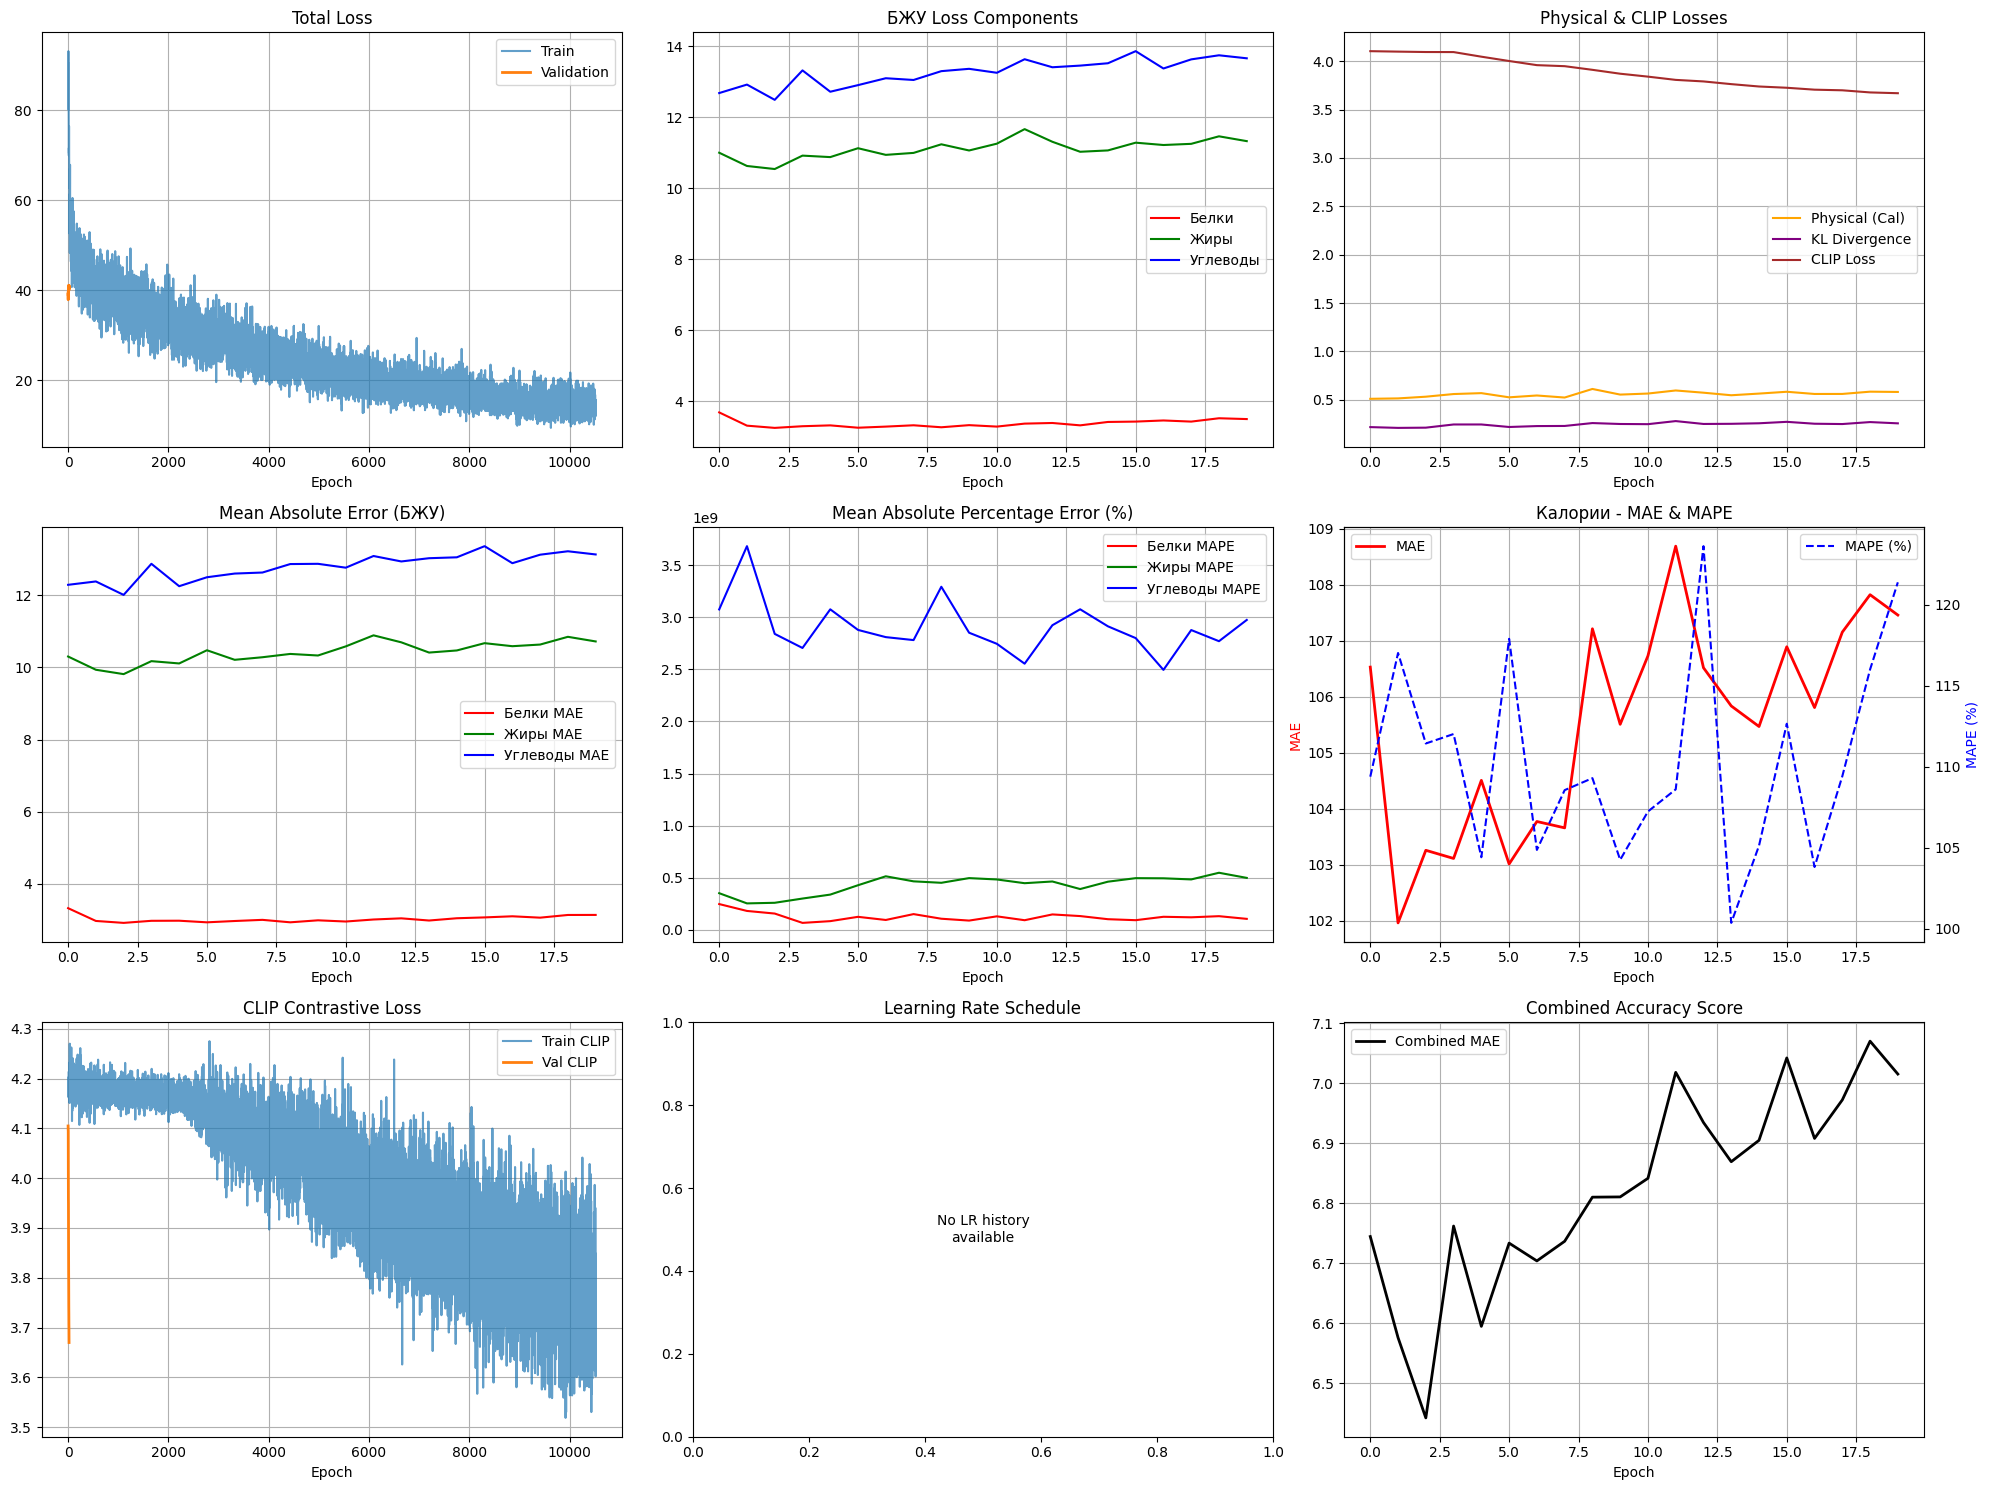

: 

In [ ]:


predictor.fit(train_loader, val_loader, epochs=20)

predictor.plot_losses(save_path='training_plots_clip.png')

In [17]:


predictor.fit(train_loader, val_loader, epochs=20)

predictor.plot_losses(save_path='training_plots_clip.png')

Начинаем обучение CLIP-based модели на 20 эпох
Устройство: cuda
Модель: EnhancedFoodNutritionNetWithCLIP
Веса функции потерь: {'b': 1.0, 'zh': 1.2, 'u': 1.5, 'cal': 2.0, 'kl': 0.7, 'clip': 0.5}

=== Эпоха 1/20 ===


Epoch 0:   0%|          | 2/526 [00:02<12:15,  1.40s/it, Loss=61.7241, Б=4.8474, Ж=18.9995, У=19.6689, Cal=1.1295, KL=0.3141, CLIP=4.1900]c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


Train Loss: 44.9700
Val Loss: 39.2356
Loss Components - Б: 3.7239, Ж: 10.9551, У: 12.7265
Physical: 0.5358, KL: 0.2188
CLIP Loss: 4.1021
MAE - Б: 3.34, Ж: 10.29, У: 12.35
MAPE - Б: 289280352.0%, Ж: 379866528.0%, У: 2641825792.0%
Калории - MAE: 106.4, MAPE: 103.2%
💾 Сохранена лучшая модель! Val Loss: 39.2356

=== Эпоха 2/20 ===


Validation: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]


Train Loss: 39.2054
Val Loss: 38.2994
Loss Components - Б: 3.3947, Ж: 10.5096, У: 12.7033
Physical: 0.5182, KL: 0.2183
CLIP Loss: 4.0982
MAE - Б: 3.05, Ж: 9.86, У: 12.27
MAPE - Б: 142350608.0%, Ж: 262668448.0%, У: 3546559232.0%
Калории - MAE: 103.6, MAPE: 96.6%
💾 Сохранена лучшая модель! Val Loss: 38.2994

=== Эпоха 3/20 ===


Epoch 2:   1%|          | 4/526 [00:05<11:18,  1.30s/it, Loss=34.9749, Б=2.7474, Ж=8.9810, У=12.4432, Cal=0.2829, KL=0.1954, CLIP=4.1657] 


KeyboardInterrupt: 

=== Dataset Analysis ===
Total items: 33661
Partitions: {'train': 33661}

Nutrition stats:
Protein: mean=5.19, std=5.53
Fat: mean=16.17, std=20.13
Carbs: mean=26.44, std=21.95
Calories: mean=271.91, std=182.62

Sample titles:
- Yogurt Parfaits
- Honey Sriracha Chicken Wings
- Shrimp and Caper Salad
- Natural Peanut Butter Chocolate Bon Bons
- Easy Cheese Sauce
- Easy Chocolate Frosting Recipe
- Cornmeal Crackers with Pumpkin Seeds
- Chocolate-Orange Angel Food Cake
- Creamed Broccoli And Cauliflower Soup Recipe
- Aunt Julie's Pineapple Cookies

Sample text descriptions:
- homemade yogurt parfaits
- cooked chicken
- fresh salad
- homemade natural peanut butter chocolate bon bons
- prepared easy cheese sauce
- easy chocolate frosting
- cooked cornmeal crackers with pumpkin seeds
- healthy chocolate-orange angel food cake
- prepared creamed broccoli and cauliflower soup
- prepared aunt julie's pineapple cookies


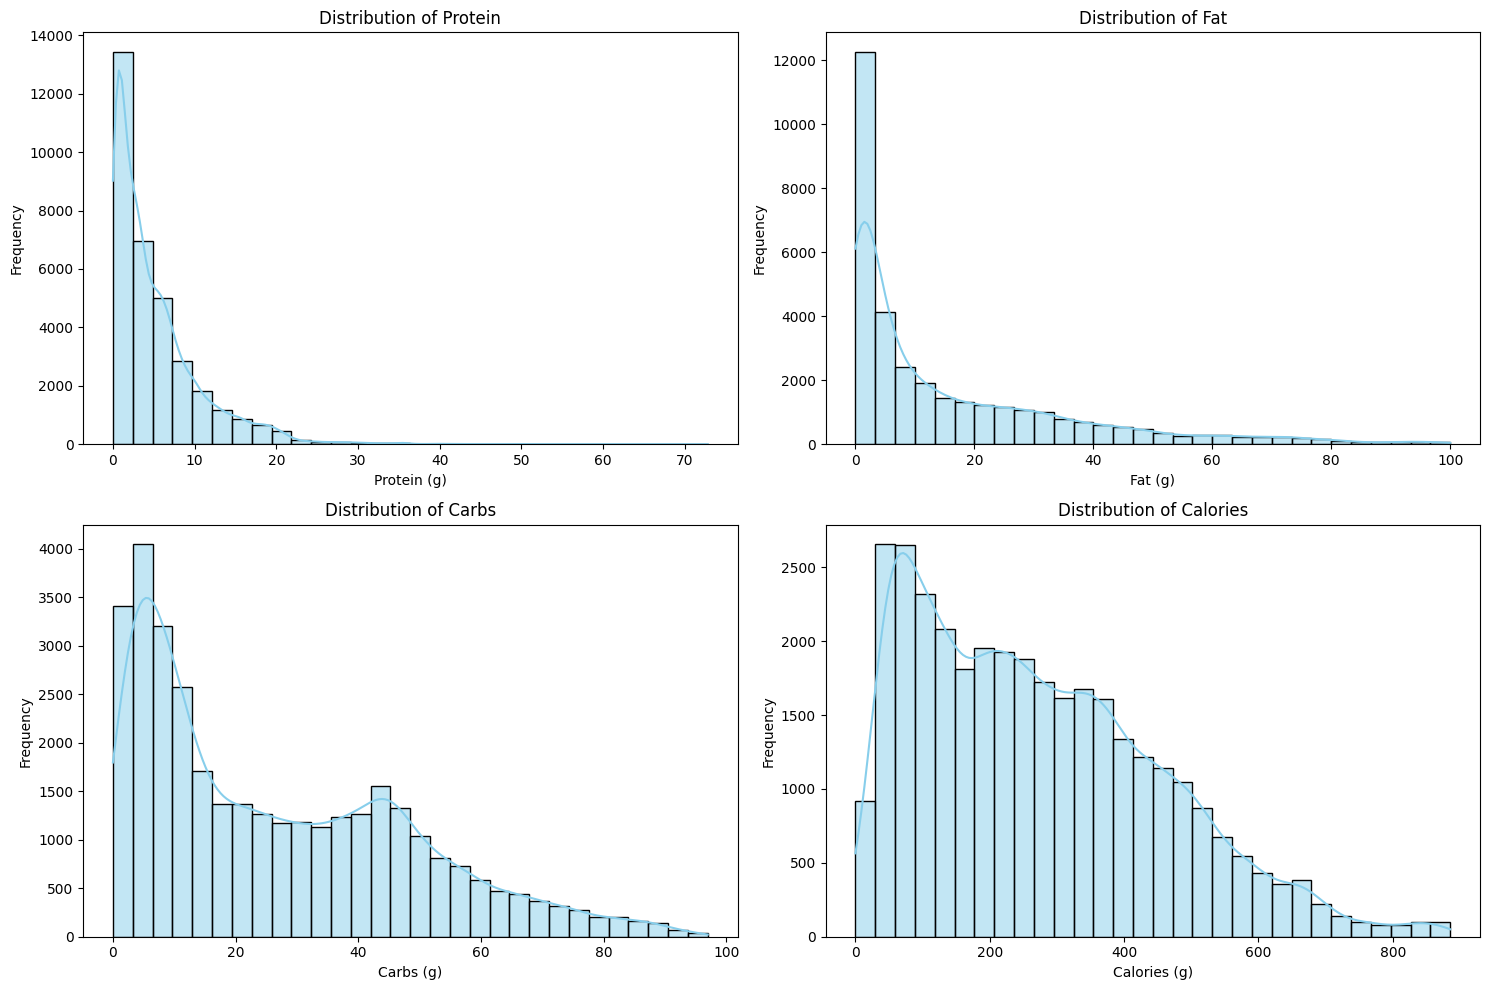

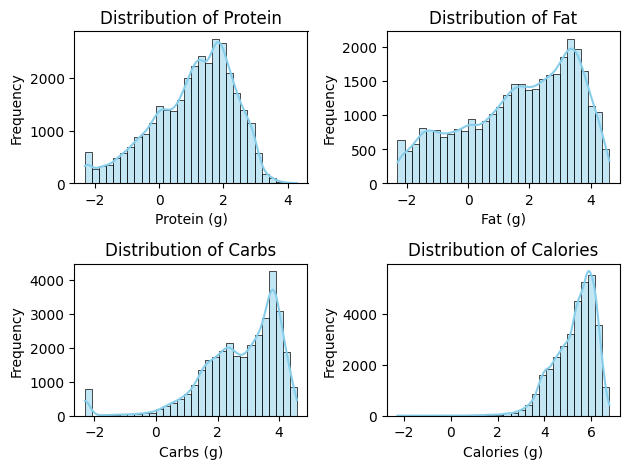

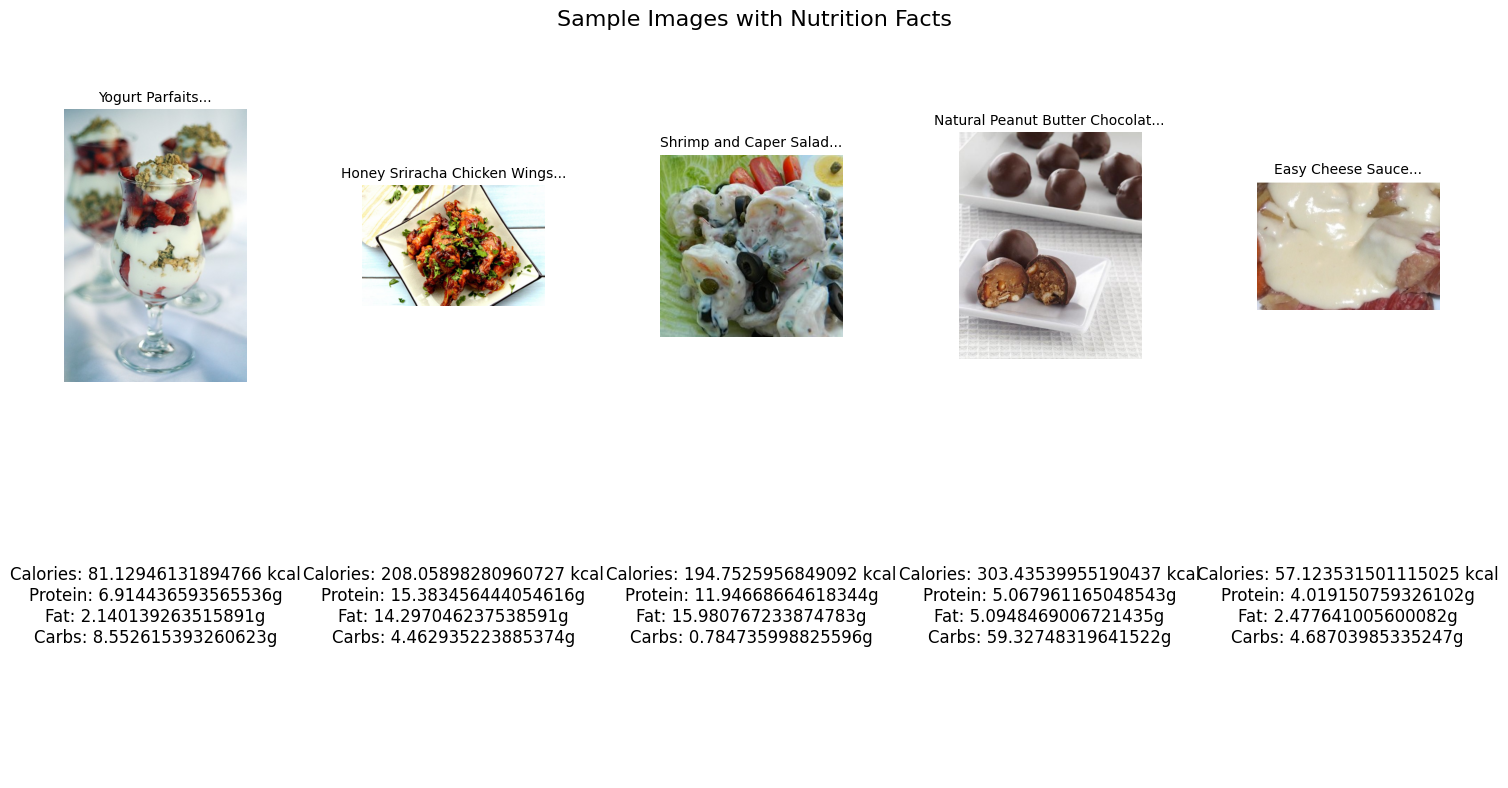

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import numpy as np



def analyze_json_dataset(json_path):
    # Загрузка и обработка данных
    data = load_json_dataset(json_path)
    df = process_json_to_dataframe(data)
    
    # Текстовая аналитика
    print("=== Dataset Analysis ===")
    print(f"Total items: {len(df)}")
    print(f"Partitions: {df['partition'].value_counts().to_dict()}")
    print("\nNutrition stats:")
    print(f"Protein: mean={df['protein'].mean():.2f}, std={df['protein'].std():.2f}")
    print(f"Fat: mean={df['fat'].mean():.2f}, std={df['fat'].std():.2f}")
    print(f"Carbs: mean={df['carbs'].mean():.2f}, std={df['carbs'].std():.2f}")
    print(f"Calories: mean={df['calories'].mean():.2f}, std={df['calories'].std():.2f}")
    
    print("\nSample titles:")
    for title in df['title'].head(10):
        print(f"- {title}")
    
    print("\nSample text descriptions:")
    for desc in df['text_description'].head(10):
        print(f"- {desc}")
    
    # Визуализация распределений
    nutrients = ['protein', 'fat', 'carbs', 'calories']
    plt.figure(figsize=(15, 10))
    
    for i, nutrient in enumerate(nutrients, 1):
        plt.subplot(2, 2, i)
        sns.histplot((df[nutrient]), kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of {nutrient.capitalize()}')
        plt.xlabel(f'{nutrient.capitalize()} (g)')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    for i, nutrient in enumerate(nutrients, 1):
        plt.subplot(2, 2, i)
        sns.histplot((np.log(df[nutrient]+0.1)), kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of {nutrient.capitalize()}')
        plt.xlabel(f'{nutrient.capitalize()} (g)')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    
    # Примеры изображений (если есть столбец 'image_path')
    if 'image_path' in df.columns:
        sample_size = min(5, len(df))  # Ограничиваем 5 примерами
        plt.figure(figsize=(15, 8))
        plt.suptitle("Sample Images with Nutrition Facts", fontsize=16)
        
        for i, (idx, row) in enumerate(df.head(sample_size).iterrows(), 1):
            try:
                # Загрузка изображения
                img = Image.open(row['image_path'])
                
                # Создание подграфика
                plt.subplot(2, sample_size, i)
                plt.imshow(img)
                plt.title(f"{row['title'][:30]}...", fontsize=10)
                plt.axis('off')
                
                # Текстовая информация о питательности
                plt.subplot(2, sample_size, i + sample_size)
                nutrition_text = (
                    f"Calories: {row['calories']} kcal\n"
                    f"Protein: {row['protein']}g\n"
                    f"Fat: {row['fat']}g\n"
                    f"Carbs: {row['carbs']}g"
                )
                plt.text(0.5, 0.5, nutrition_text, 
                         ha='center', va='center', fontsize=12)
                plt.axis('off')
                
            except Exception as e:
                print(f"Error loading image {row['image_path']}: {str(e)}")
                plt.subplot(2, sample_size, i)
                plt.text(0.5, 0.5, "Image not available", 
                         ha='center', va='center', fontsize=10)
                plt.axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    else:
        print("\nNo 'image_path' column found - skipping image display")

analyze_json_dataset("./processed_recipes/train_fix.json")

In [38]:
json_path = "./processed_recipes/train_fix.json"
data = load_json_dataset(json_path)
df = process_json_to_dataframe(data)

In [39]:
df

,id,title,text_description,image_path,protein,fat,carbs,calories,protein_prop,fat_prop,carb_prop,partition,total_weight_g
0,000095fc1d,Yogurt Parfaits,natural yogurt parfaits,train\a\1\3\7\a1374cdd98.jpg,6.914437,2.140139,8.552615,81.129461,0.392705,0.121549,0.485746,train,409.296000
1,00059b093b,Honey Sriracha Chicken Wings,delicious honey sriracha chicken wings,train\e\4\1\2\e412a11941.jpg,15.383456,14.297046,4.462935,208.058983,0.450554,0.418735,0.130711,train,1579.409333
2,0005fc89f7,Shrimp and Caper Salad,mixed salad,train\5\0\2\a\502a40d740.jpg,11.946687,15.980767,0.784736,194.752596,0.416084,0.556585,0.027331,train,1574.431917
3,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,natural natural peanut butter chocolate bon bons,train\2\3\6\0\2360331788.jpg,5.067961,5.094847,59.327483,303.435400,0.072930,0.073317,0.853752,train,5356.000000
4,00073a6b36,Easy Cheese Sauce,easy cheese sauce,train\3\d\f\9\3df946082c.jpg,4.019151,2.477641,4.687040,57.123532,0.359372,0.221538,0.419091,train,3426.114280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33656,fff9cafaa6,French Bread Rolls,tasty french bread rolls,train\4\e\7\9\4e79db9632.jpg,7.001239,4.066914,51.785006,271.747212,0.111390,0.064705,0.823905,train,807.000000
33657,fffa89c6e3,Raspberry Wasabi Mustard,cooked raspberry wasabi mustard,train\6\e\7\9\6e79fc21f3.jpg,3.620182,3.131620,4.430821,60.388593,0.323733,0.280043,0.396224,train,199.437500
33658,fffb3bbff2,Granola Supreme,granola supreme,train\2\1\6\5\2165d028e4.jpg,1.147211,25.488530,54.441425,451.751314,0.014150,0.314374,0.671477,train,26290.141730
33659,fffd4b124b,Almond Bark Candy,homemade almond bark candy,train\8\f\d\6\8fd61894b2.jpg,10.677064,23.820486,43.630672,431.615316,0.136661,0.304890,0.558450,train,4149.592000


In [55]:


train_loader = create_json_dataloader(
    json_path="./processed_recipes/train_fix.json",
    batch_size=64,
    shuffle=True,
    partition='train',
    base_image_path="",
    use_text=True,
       transform=  T.Compose([
                T.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomAffine(
                    degrees=15,         # Небольшие повороты
                    translate=(0.1, 0.1),  # Сдвиги
                    scale=(0.9, 1.1),  # Масштабирование
                    shear=10          
                ),
                T.RandomApply([T.ColorJitter(
                        brightness=0.3, 
                        contrast=0.3,
                        saturation=0.2,
                        hue=0.02)],
                    p=0.8),
                T.RandomGrayscale(p=0.2),
                T.RandomPerspective(distortion_scale=0.2, p=0.3),
                T.RandomApply([GaussianBlur()], p=0.2),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                T.RandomErasing(p=0.2, scale=(0.02, 0.1)), 
            ])
)


val_loader = create_json_dataloader(
    json_path="./processed_recipes/val_fix.json",
    batch_size=64,
    shuffle=False,
    partition='val',
    base_image_path=base_image_path,
    use_text=True
)


test_loader = create_json_dataloader(
    json_path="./processed_recipes/test_fix.json",
    batch_size=64,
    shuffle=False,
    partition='test',
    base_image_path=base_image_path,
    use_text=True
)

Loaded 33661 items from JSON
Partitions: {'train': 33661}
Filtered to 33661 items for partition 'train'
Loaded 2567 items from JSON
Partitions: {'val': 2567}
Filtered to 2567 items for partition 'val'
Loaded 2719 items from JSON
Partitions: {'test': 2719}
Filtered to 2719 items for partition 'test'


In [56]:
predictor = EnhancedCLIPNutritionPredictor(
    model_config={
        'clip_model_name': 'RN50',
        'freeze_text_encoder': False,
        'use_text_features': True
    }
)

c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Text encoder params: 147
Other params: 428


In [57]:


predictor.fit(train_loader, val_loader, epochs=70)

predictor.plot_losses(save_path='training_plots_clip.png')

Начинаем обучение CLIP-based модели на 70 эпох
Устройство: cuda
Модель: EnhancedFoodNutritionNetWithCLIP
Веса функции потерь: {'b': 1.0, 'zh': 1.2, 'u': 1.5, 'cal': 2.0, 'kl': 0.7, 'clip': 0.5}

=== Эпоха 1/70 ===


Epoch 0:  27%|██▋       | 140/526 [02:33<06:38,  1.03s/it, Loss=6.2615, Б=0.4771, Ж=0.9357, У=0.5921, Cal=0.7430, KL=0.2961, CLIP=4.1600]  c:\Users\User\anaconda3\envs\MTS\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation: 100%|██████████| 41/41 [00:20<00:00,  2.00it/s]


Train Loss: 8.3564
Val Loss: 5.6587
Loss Components - Б: 0.4408, Ж: 0.7387, У: 0.5989
Physical: 0.6024, KL: 0.2948
CLIP Loss: 4.0444
MAE - Б: 3.73, Ж: 12.11, У: 16.89
MAPE - Б: 328440352.0%, Ж: 444708704.0%, У: 5296057344.0%
Калории - MAE: 129.3, MAPE: 109.9%
💾 Сохранена лучшая модель! Val Loss: 5.6587

=== Эпоха 2/70 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.21it/s]


Train Loss: 5.5059
Val Loss: 5.2762
Loss Components - Б: 0.4152, Ж: 0.6803, У: 0.5923
Physical: 0.5164, KL: 0.2694
CLIP Loss: 3.8697
MAE - Б: 3.69, Ж: 11.57, У: 16.45
MAPE - Б: 276564832.0%, Ж: 529735392.0%, У: 6490667008.0%
Калории - MAE: 107.3, MAPE: 115.7%
💾 Сохранена лучшая модель! Val Loss: 5.2762

=== Эпоха 3/70 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


Train Loss: 5.0304
Val Loss: 4.7938
Loss Components - Б: 0.3661, Ж: 0.5728, У: 0.4620
Physical: 0.5012, KL: 0.2265
CLIP Loss: 3.7724
MAE - Б: 3.40, Ж: 10.38, У: 13.80
MAPE - Б: 198616144.0%, Ж: 459454912.0%, У: 4906216960.0%
Калории - MAE: 106.1, MAPE: 95.2%
💾 Сохранена лучшая модель! Val Loss: 4.7938

=== Эпоха 4/70 ===


Validation: 100%|██████████| 41/41 [00:20<00:00,  1.96it/s]


Train Loss: 4.4394
Val Loss: 4.5923
Loss Components - Б: 0.3076, Ж: 0.5445, У: 0.4326
Physical: 0.4965, KL: 0.2098
CLIP Loss: 3.6850
MAE - Б: 3.07, Ж: 10.10, У: 12.89
MAPE - Б: 132414888.0%, Ж: 319557760.0%, У: 4365507584.0%
Калории - MAE: 103.7, MAPE: 93.7%
💾 Сохранена лучшая модель! Val Loss: 4.5923

=== Эпоха 5/70 ===


Validation: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


Train Loss: 4.0089
Val Loss: 4.5429
Loss Components - Б: 0.3046, Ж: 0.5469, У: 0.4242
Physical: 0.4896, KL: 0.2193
CLIP Loss: 3.6259
MAE - Б: 3.02, Ж: 10.29, У: 12.74
MAPE - Б: 98933368.0%, Ж: 231423392.0%, У: 3769067008.0%
Калории - MAE: 102.7, MAPE: 99.2%
💾 Сохранена лучшая модель! Val Loss: 4.5429

=== Эпоха 6/70 ===


Validation: 100%|██████████| 41/41 [00:20<00:00,  1.98it/s]


Train Loss: 3.6575
Val Loss: 4.5511
Loss Components - Б: 0.2921, Ж: 0.5543, У: 0.4142
Physical: 0.5019, KL: 0.2243
CLIP Loss: 3.6236
MAE - Б: 2.94, Ж: 10.32, У: 12.55
MAPE - Б: 115915120.0%, Ж: 394923904.0%, У: 3511118592.0%
Калории - MAE: 103.7, MAPE: 93.1%

=== Эпоха 7/70 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


Train Loss: 3.3747
Val Loss: 4.5909
Loss Components - Б: 0.2983, Ж: 0.5617, У: 0.4148
Physical: 0.5240, KL: 0.2264
CLIP Loss: 3.5797
MAE - Б: 3.00, Ж: 10.39, У: 12.60
MAPE - Б: 113388104.0%, Ж: 257864016.0%, У: 3530779136.0%
Калории - MAE: 104.5, MAPE: 98.4%

=== Эпоха 8/70 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.07it/s]


Train Loss: 3.1367
Val Loss: 4.6500
Loss Components - Б: 0.3274, Ж: 0.5624, У: 0.4277
Physical: 0.5200, KL: 0.2495
CLIP Loss: 3.5830
MAE - Б: 3.11, Ж: 10.42, У: 12.98
MAPE - Б: 68335720.0%, Ж: 292368896.0%, У: 3048652032.0%
Калории - MAE: 104.0, MAPE: 97.8%

=== Эпоха 9/70 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.19it/s]


Train Loss: 2.9144
Val Loss: 4.6088
Loss Components - Б: 0.3085, Ж: 0.5581, У: 0.4235
Physical: 0.5002, KL: 0.2344
CLIP Loss: 3.6617
MAE - Б: 3.05, Ж: 10.44, У: 12.81
MAPE - Б: 114460728.0%, Ж: 327368256.0%, У: 3106915328.0%
Калории - MAE: 103.8, MAPE: 95.3%

=== Эпоха 10/70 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 2.7180
Val Loss: 4.6646
Loss Components - Б: 0.3164, Ж: 0.5705, У: 0.4256
Physical: 0.5205, KL: 0.2323
CLIP Loss: 3.6431
MAE - Б: 3.13, Ж: 10.52, У: 12.85
MAPE - Б: 156057712.0%, Ж: 393888544.0%, У: 3444628224.0%
Калории - MAE: 104.1, MAPE: 96.5%

=== Эпоха 11/70 ===


Validation: 100%|██████████| 41/41 [00:19<00:00,  2.09it/s]


Epoch 00011: reducing learning rate of group 0 to 7.0000e-05.
Epoch 00011: reducing learning rate of group 1 to 7.0000e-06.
Train Loss: 2.5417
Val Loss: 4.8160
Loss Components - Б: 0.3176, Ж: 0.5859, У: 0.4432
Physical: 0.5588, KL: 0.2519
CLIP Loss: 3.6733
MAE - Б: 3.04, Ж: 10.63, У: 13.22
MAPE - Б: 114581512.0%, Ж: 308702208.0%, У: 3446338048.0%
Калории - MAE: 107.5, MAPE: 95.4%

=== Эпоха 12/70 ===


Validation: 100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


Train Loss: 2.3049
Val Loss: 4.7887
Loss Components - Б: 0.3239, Ж: 0.5807, У: 0.4371
Physical: 0.5162, KL: 0.2612
CLIP Loss: 3.7942
MAE - Б: 3.04, Ж: 10.58, У: 13.30
MAPE - Б: 99831608.0%, Ж: 370640352.0%, У: 3421317632.0%
Калории - MAE: 104.6, MAPE: 97.3%

=== Эпоха 13/70 ===


Validation: 100%|██████████| 41/41 [00:20<00:00,  2.02it/s]


Train Loss: 2.1025
Val Loss: 4.9478
Loss Components - Б: 0.3244, Ж: 0.5876, У: 0.4512
Physical: 0.5361, KL: 0.2692
CLIP Loss: 3.9619
MAE - Б: 3.07, Ж: 10.81, У: 13.70
MAPE - Б: 94239864.0%, Ж: 343908896.0%, У: 3714821376.0%
Калории - MAE: 106.8, MAPE: 104.5%

=== Эпоха 14/70 ===


Epoch 13:   1%|          | 5/526 [00:06<10:54,  1.26s/it, Loss=2.2861, Б=0.2224, Ж=0.2181, У=0.1862, Cal=0.1273, KL=0.0922, CLIP=2.4072]


KeyboardInterrupt: 